# PCA Pairs Trading in the Korea Equities Market

#### Import Packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#### System Setting

In [15]:
# Prevent Scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Pickle 로딩 및 데이터 전처리

In [238]:
def finding_pairs(df_price):
    # Normalization
    df_return = df_price.pct_change()
    df_return = df_return.dropna(axis=0)
    for col in df_return.columns:
        df_return[col] = (df_return[col] - df_return[col].mean()) / df_return[col].std()
    
    # PCA on return space
    pca = PCA()
    pca.fit(df_return)
    return_pca = pca.transform(df_return)
    
    # Eigen portfolio returns
    df_eig = pd.DataFrame()
    eig_lim = 5
    for i in range(eig_lim):
        df_eig[i] = df_return.mul(pca.components_[i], axis=1).sum(axis=1)
    
    # regression (X: Eigen portfolios(Risk Factor from PCA), Y: Individual Return)
    df_reg = df_eig.copy()
    df_reg = sm.add_constant(df_reg)
    
    # Factor Loading estimation(OLS) for each stocks
    df_params = pd.DataFrame()
    df_pval = pd.DataFrame()
    for ticker in df_return.columns:
        results = sm.OLS(df_return.loc[:,ticker] ,df_reg).fit()
        df_params[ticker] = results.params
        df_pval[ticker] = results.pvalues
    
    df_params = df_params.T
    df_pval = df_pval.T
    
    # First Clustering: Grouping stocks which have same confident factors
    pval_thr = 0.05
    df_pval_bool = df_pval < pval_thr
    
    def classify_duplicate(df):
        df_c = df.copy()
        df_list = []
        df_non = pd.DataFrame()
        idx_list = df.index
        for idx in idx_list:
            if idx not in df_c.index:
                continue
            # print(idx)
            temp_df = pd.DataFrame()
            # temp_df[idx] = df_c.loc[idx,:]
            temp_series = df_c.loc[idx, :]
            df_c = df_c.drop(idx)
            cnt = 0
            for idx2 in df_c.index:
                if (temp_series == df_c.loc[idx2, :]).all():
                    # print(idx, idx2)
                    temp_df[idx2] = df_c.loc[idx2, :]
                    df_c = df_c.drop(idx2)
                    cnt += 1
            if cnt == 0:
                df_non[idx] = temp_series
            else:
                temp_df[idx] = temp_series
                df_list.append(temp_df.T)
        return df_list, df_non.T

    classified_list, df_nc = classify_duplicate(df_pval_bool)
    
    # Second Clustering: Grouping stocks which have similar factor loadings
    for d in classified_list[:10]:
        target_tickers = d.index
        factor_sig = d.iloc[0,:]
        k = factor_sig.sum()
    
        kmeans_pca = KMeans(n_clusters = k, init = 'k-means++', random_state=1)
        kmeans_pca.fit(df_params.loc[target_tickers, factor_sig])
        d['cluster'] = kmeans_pca.labels_
        
    # target_c = classified_list[0]
    # stocks = target_c.index[target_c['cluster'] == 0]
    # pvals, pairs = find_cointegrated_pairs_adf(df_price.loc[:, stocks])
    # df_pairs = pd.DataFrame(pairs, columns=['s1', 's2', 'pval', 'beta', 'alpha'])
    # df_pairs = df_pairs.sort_index(by='pval').reset_index(drop=True)
    
    df_pairs_total = pd.DataFrame(columns=['s1', 's2', 'pval', 'beta', 'alpha', 'cluster'])
    for i, c1 in enumerate(classified_list[:2]):
        df_pairs_semi = pd.DataFrame(columns=['s1', 's2', 'pval', 'beta', 'alpha', 'cluster'])
        print("Finding Pairs from {} Cluster({} stocks in the cluster)..".format(i, len(c1)))
        for c2 in c1['cluster'].unique():
            print("\tFinding Pairs from {} Small Cluster".format(c2))
            stocks = c1.index[c1['cluster'] == c2]
            pvals, pairs = find_cointegrated_pairs_adf(df_price.loc[:, stocks])
            df_pairs = pd.DataFrame(pairs, columns=['s1', 's2', 'pval', 'beta', 'alpha', 'bp', 'ap', 'r2'])
            df_pairs = df_pairs.sort_index(by='pval').reset_index(drop=True)
            df_pairs['cluster'] = str(i) + '_' + str(c2)
            df_pairs_semi = df_pairs_semi.append(df_pairs, ignore_index=True)
        # Select Top 5 Pairs from each Clusters
        # df_pairs_semi = df_pairs_semi[:5]
        df_pairs_total = df_pairs_total.append(df_pairs_semi, ignore_index=True)
            
    
    return df_pairs_total


In [239]:
def adf_coint_test(df1, df2):
    df2_temp = df2.copy()
    df2_temp = sm.add_constant(df2_temp)
    results = sm.OLS(df1, df2_temp).fit()
    coint_pval= adfuller(results.resid)[1]
    alpha = results.params[0]
    beta = results.params[1]
    ap = results.pvalues[0]
    bp = results.pvalues[1]
    r2 = results.rsquared
    
    return coint_pval, beta, alpha, bp, ap, r2

In [240]:
def find_cointegrated_pairs_adf(dataframe, critial_level=0.02):
    n = dataframe.shape[1]  # the length of dateframe
    pvalue_matrix = np.ones((n, n))  # initialize the matrix of p
    keys = dataframe.keys()  # get the column names
    pairs = []  # initilize the list for cointegration
    for i in range(n):
        for j in range(i + 1, n):  # for j bigger than i
            stock1 = np.log(dataframe[keys[i]])  # obtain the price of two contract
            stock2 = np.log(dataframe[keys[j]])
            # stock1 = dataframe[keys[i]]  # obtain the price of two contract
            # stock2 = dataframe[keys[j]]
            pval, beta, alpha, bp, ap, r2 = adf_coint_test(stock1, stock2)  # get conintegration
            pvalue_matrix[i, j] = pval
            if pval < critial_level:  # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pval, beta, alpha, bp, ap, r2))  # record the contract with that p-value

    return pvalue_matrix, pairs

In [220]:
from scipy.stats.stats import pearsonr
i = 19
logp1 = np.log(df_price[df_pairs_t.loc[i, 's1']])
logp2 = np.log(df_price[df_pairs_t.loc[i, 's2']])
a = df_pairs_t.loc[i, 'alpha']
b = df_pairs_t.loc[i, 'beta']
logp2 = logp2 * b + a
logp1 = logp1 - logp1.shift(1)
logp2 = logp2 - logp2.shift(1)
logp1 = logp1.dropna()
logp2 = logp2.dropna()

pearsonr(logp1, logp2)

(0.40363630587961125, 6.152099954105311e-11)

In [243]:
def draw_pairs(df_pairs):
    # font_path = 'C:/Windows/Fonts/H2GTRM.TTF'
    # fontprop = FontProperties(fname=font_path, size=15)
    for i in df_pairs.index:
        s1_code = df_price[df_pairs.loc[i, 's1']].name
        s2_code = df_price[df_pairs.loc[i, 's2']].name
        s1_name = s1_code # ticker_series[s1_code]
        s2_name = s2_code # ticker_series[s2_code]
        
        logp1 = np.log(df_price[df_pairs.loc[i, 's1']])
        logp2 = np.log(df_price[df_pairs.loc[i, 's2']])
        a = df_pairs.loc[i, 'alpha']
        b = df_pairs.loc[i, 'beta']

        pd.Series(logp1).plot(label=s1_name)
        pd.Series(logp2 * b + a).plot(label=s2_name)
        print('{}th'.format(i))
        print(df_pairs.loc[i, 'cluster'])
        print(df_pairs.loc[i, 'pval'])
        print('Ap: ' + str(df_pairs.loc[i, 'ap']))
        print('Bp: ' + str(df_pairs.loc[i, 'bp']))
        print('R2: ' + str(df_pairs.loc[i, 'r2']))
        
        
        plt.legend()
        plt.show()
        plt.close()

0th
0_2
0.001144683531802667
Ap: 0.006270900593719432
Bp: 1.3708271499917989e-168
R2: 0.9579960078350956


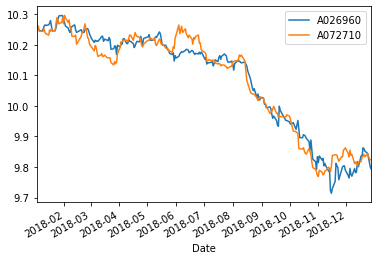

1th
0_2
0.0012812703253894271
Ap: 4.8257150106958503e-119
Bp: 1.4188996942330151e-24
R2: 0.351776197724298


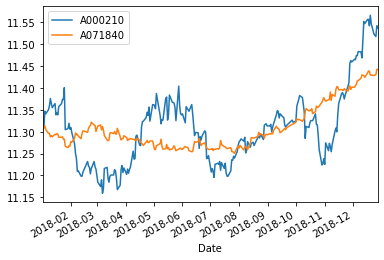

2th
0_2
0.001847250826317687
Ap: 3.365352628951706e-127
Bp: 1.0399353107242645e-17
R2: 0.26218563028980657


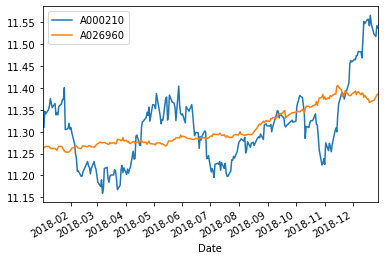

3th
0_2
0.0023400868604748055
Ap: 7.098929020868669e-135
Bp: 7.529135663432393e-12
R2: 0.17645104748425922


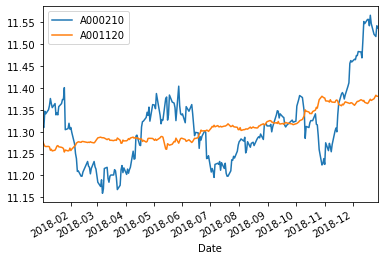

4th
0_2
0.0033616668947493446
Ap: 0.0007266527775442978
Bp: 1.3167135028165158e-139
R2: 0.9270950353574439


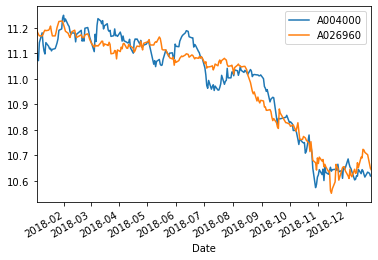

5th
0_2
0.003804810492923638
Ap: 3.759232482480427e-116
Bp: 3.424272811776648e-13
R2: 0.19687046469467862


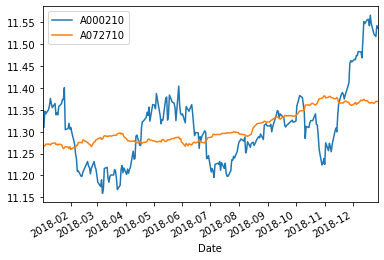

6th
0_2
0.0055505479044663355
Ap: 1.1483003554405813e-132
Bp: 1.4909243416134617e-10
R2: 0.1562806921401495


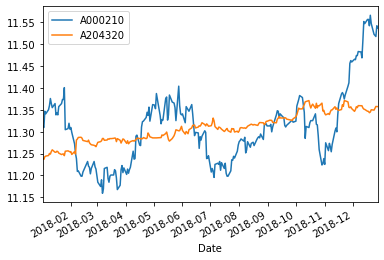

7th
0_2
0.005817660104581982
Ap: 2.428240606975396e-137
Bp: 2.563097163410387e-19
R2: 0.2841922849161945


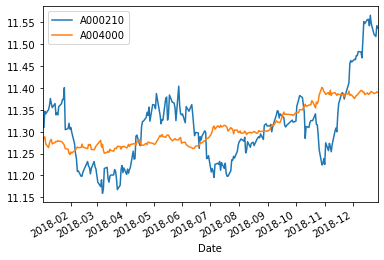

8th
0_2
0.006497496796717506
Ap: 5.183197893431283e-65
Bp: 1.2637328853571725e-76
R2: 0.7585016481948622


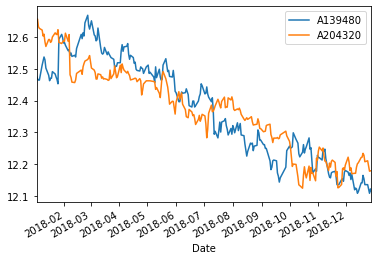

9th
0_2
0.008304777273480552
Ap: 7.914419473775078e-14
Bp: 8.322204804506139e-137
R2: 0.9231053538326018


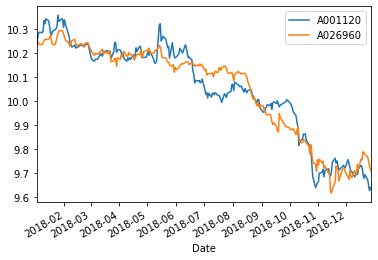

10th
0_2
0.00844972551149265
Ap: 2.207344434420365e-111
Bp: 3.480899282058575e-92
R2: 0.8203370118888413


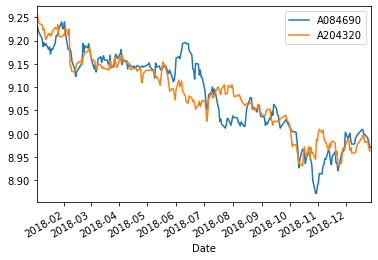

11th
0_2
0.01155109501238524
Ap: 0.002027836573117648
Bp: 2.0237474341939835e-98
R2: 0.8404237494213653


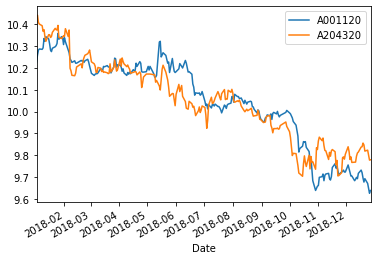

12th
0_2
0.012134595329478842
Ap: 8.052959046568347e-27
Bp: 1.3636763868709141e-78
R2: 0.7673628561431307


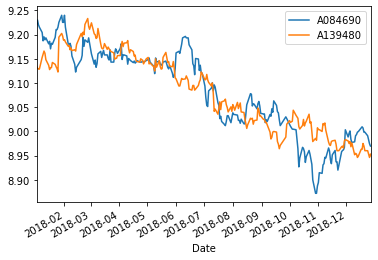

13th
0_2
0.014255817520773163
Ap: 4.317477925594749e-71
Bp: 1.0399013496036293e-05
R2: 0.07732838543977638


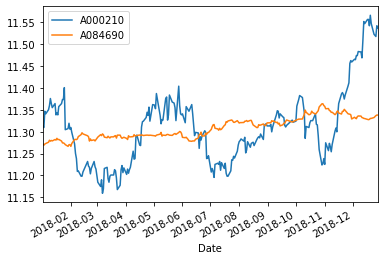

14th
0_2
0.014439556701244284
Ap: 1.724435448362074e-113
Bp: 2.946037234993495e-06
R2: 0.08650769187359386


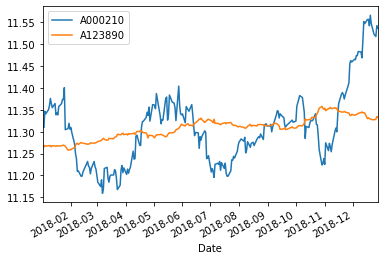

15th
0_2
0.014765235577779106
Ap: 1.29377029384914e-94
Bp: 3.0180079921396596e-63
R2: 0.6886096422235665


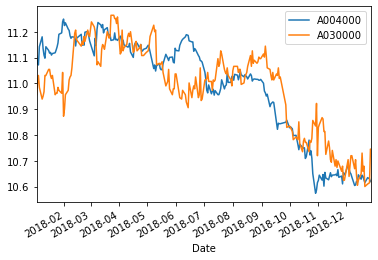

16th
0_2
0.016884888134361314
Ap: 1.0658577719804309e-186
Bp: 2.643218038797787e-37
R2: 0.4905458417614793


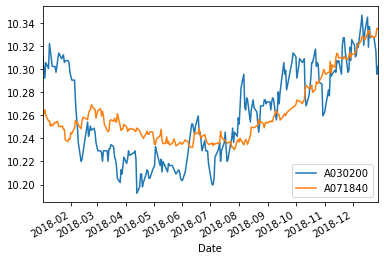

17th
0_2
0.018303412205569906
Ap: 1.0066105039017508e-188
Bp: 7.482396843471461e-26
R2: 0.3672396912520409


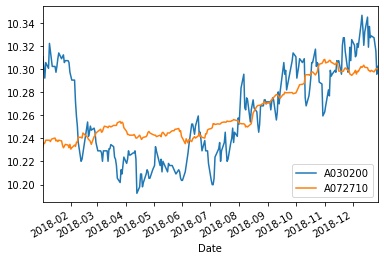

18th
0_1
2.671275710460524e-06
Ap: 6.463528507378477e-31
Bp: 3.7548397365775456e-53
R2: 0.6228137499539403


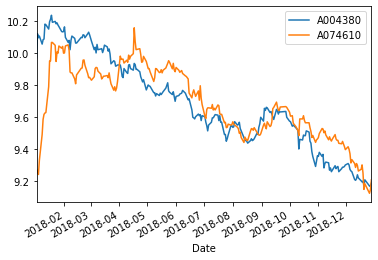

19th
0_1
3.23386420225386e-05
Ap: 2.262309815133475e-24
Bp: 1.5831144291906859e-96
R2: 0.8345741349497584


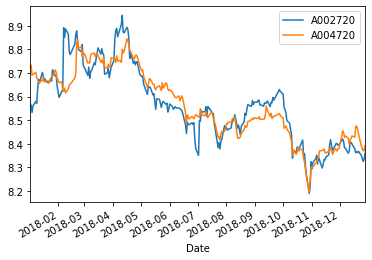

20th
0_1
0.00010400770726567163
Ap: 5.60607670538635e-69
Bp: 1.0076235532123538e-125
R2: 0.9050584048995765


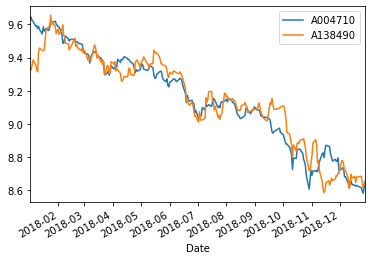

21th
0_1
0.0002267496401387919
Ap: 3.661792484154994e-30
Bp: 6.019104733768873e-64
R2: 0.6927237154016521


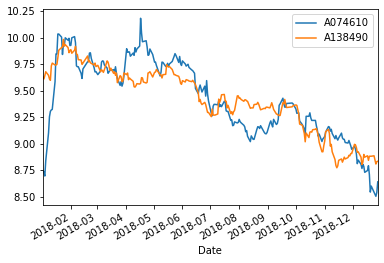

22th
0_1
0.00036760268080089707
Ap: 5.275567033914111e-215
Bp: 7.903071596350267e-103
R2: 0.8532552891966061


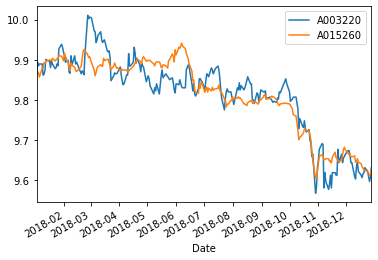

23th
0_1
0.0005609082181343118
Ap: 1.3260196358603425e-149
Bp: 2.0379002314484827e-33
R2: 0.4516174399191476


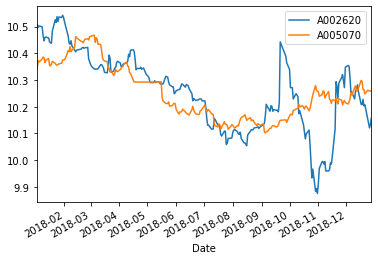

24th
0_1
0.0005942288170134633
Ap: 7.119517820712524e-51
Bp: 3.512712189187799e-47
R2: 0.5775553463423075


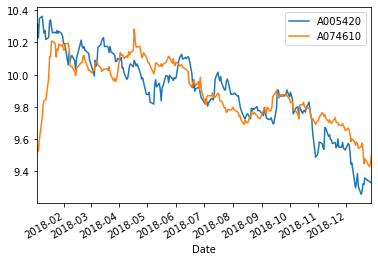

25th
0_1
0.0012270150759667359
Ap: 0.007552763967210243
Bp: 1.6352057626491706e-82
R2: 0.7840708875522611


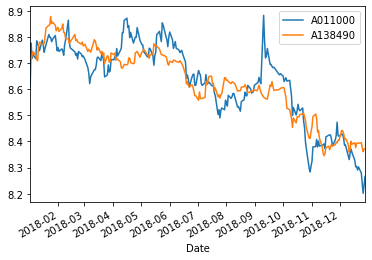

26th
0_1
0.001299286345046005
Ap: 1.8550585615363492e-106
Bp: 4.092295940694792e-65
R2: 0.6994637104378361


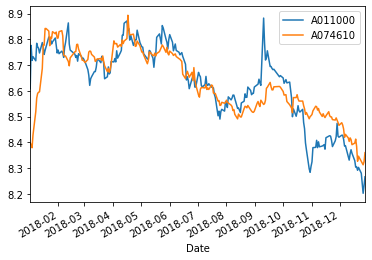

27th
0_1
0.0016287773137249049
Ap: 4.53974621333312e-64
Bp: 1.0637769014010773e-50
R2: 0.6048421588734327


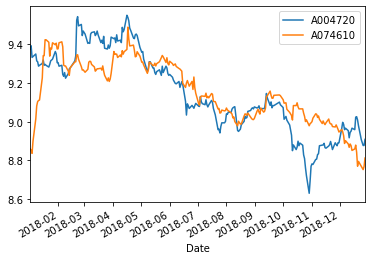

28th
0_1
0.0019191976503097237
Ap: 1.8119056533715654e-38
Bp: 1.1022948658445118e-78
R2: 0.7677711062231766


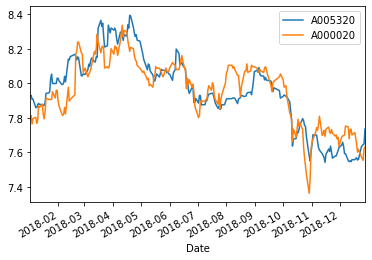

29th
0_1
0.0020152471769496337
Ap: 2.097941606951776e-06
Bp: 4.48527478544777e-65
R2: 0.6992362777126735


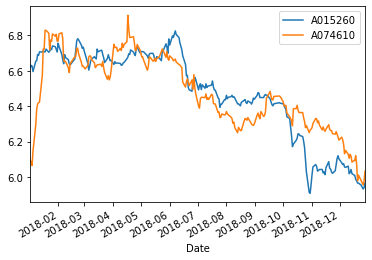

30th
0_1
0.0023093642997413406
Ap: 0.0027411865354139836
Bp: 1.8978054163838202e-38
R2: 0.5014709889262816


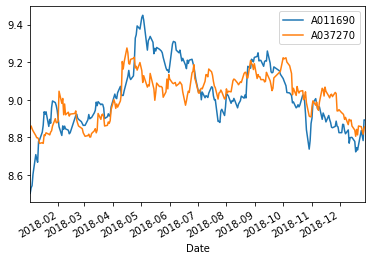

31th
0_1
0.002382200980296348
Ap: 0.000280818378549378
Bp: 1.984125374697864e-65
R2: 0.7012532958077246


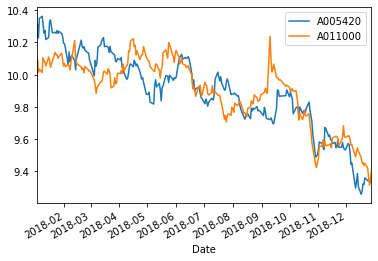

32th
0_1
0.0024264276850155773
Ap: 8.72039201617513e-47
Bp: 3.2019685459296707e-93
R2: 0.8238421735594267


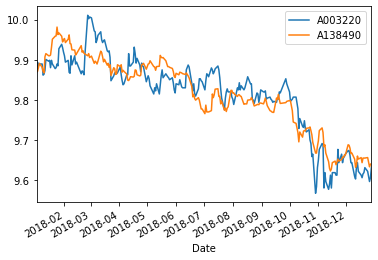

33th
0_1
0.0032193777824177246
Ap: 6.701805265423793e-06
Bp: 6.17165585559551e-09
R2: 0.13052982705841332


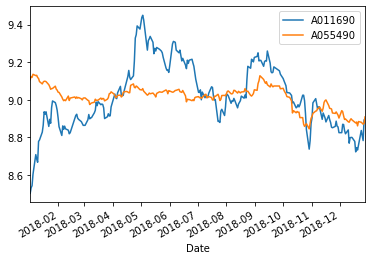

34th
0_1
0.003871564976704657
Ap: 1.301728814421548e-141
Bp: 1.010951186423781e-113
R2: 0.8807129153434959


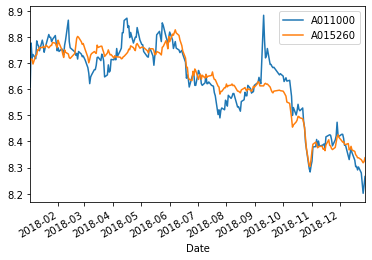

35th
0_1
0.004117589527479696
Ap: 1.0717325087830177e-111
Bp: 7.759828991053e-23
R2: 0.33015153142207754


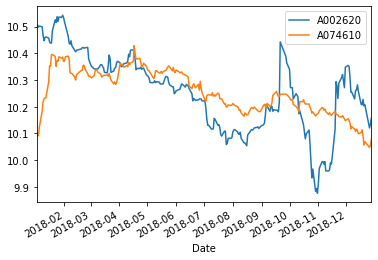

36th
0_1
0.004157873540768807
Ap: 9.93712449548678e-08
Bp: 2.7509608244521293e-75
R2: 0.752282895378753


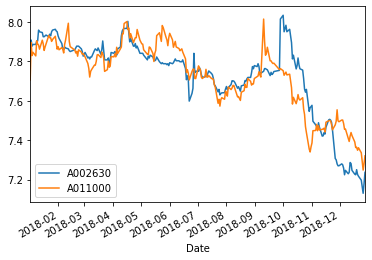

37th
0_1
0.004261216695928871
Ap: 1.0406584964277883e-54
Bp: 5.674250744901677e-31
R2: 0.4256407699712259


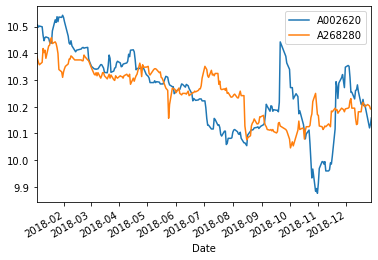

38th
0_1
0.005177783177337494
Ap: 4.0040617194635725e-08
Bp: 7.019429907305777e-18
R2: 0.2645519894093551


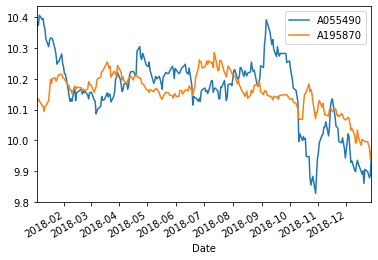

39th
0_1
0.005341139253079355
Ap: 1.675110868484793e-40
Bp: 1.3668414572973358e-49
R2: 0.5964382215217137


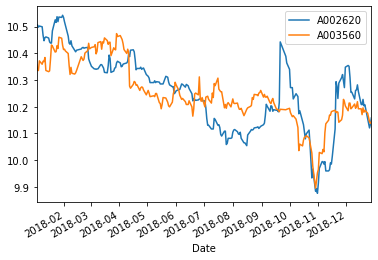

40th
0_1
0.005967885865934226
Ap: 2.76445831034758e-78
Bp: 1.686904446730033e-47
R2: 0.5801009051475025


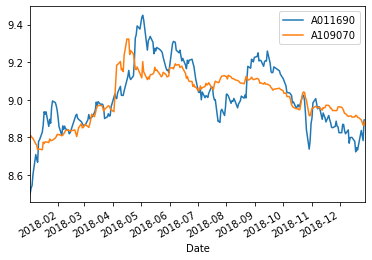

41th
0_1
0.006024181666414419
Ap: 3.863336340239018e-43
Bp: 2.1031074515559966e-31
R2: 0.4303075858742389


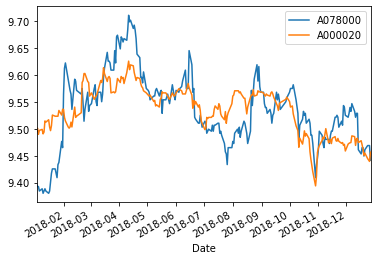

42th
0_1
0.006289318317191976
Ap: 0.6134151753323723
Bp: 7.891593208310909e-62
R2: 0.68011228796684


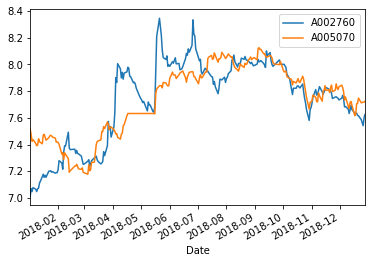

43th
0_1
0.006772149186716326
Ap: 2.2023466576548794e-76
Bp: 4.813758500282069e-42
R2: 0.534322286127551


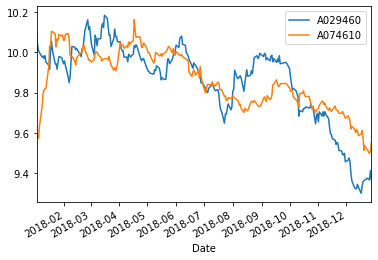

44th
0_1
0.006864806472058802
Ap: 1.7379315203563273e-12
Bp: 1.1763326437392484e-56
R2: 0.647089635140847


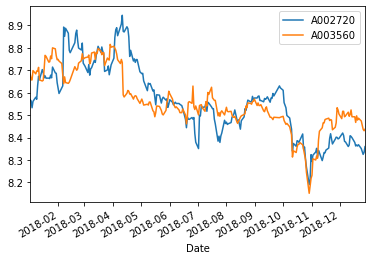

45th
0_1
0.00721018824855502
Ap: 8.159287992679782e-26
Bp: 4.751332759115356e-09
R2: 0.13236000329102682


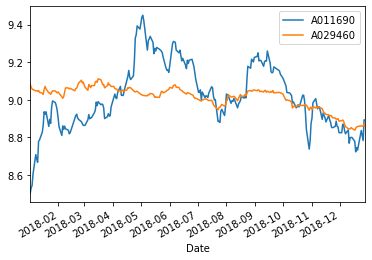

46th
0_1
0.007920130953680342
Ap: 1.754875080326226e-74
Bp: 2.6299047128117644e-62
R2: 0.682998686493291


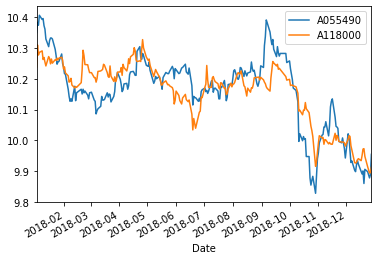

47th
0_1
0.009369626910318823
Ap: 3.3508484716987847e-08
Bp: 2.500701333319754e-109
R2: 0.8703176590911172


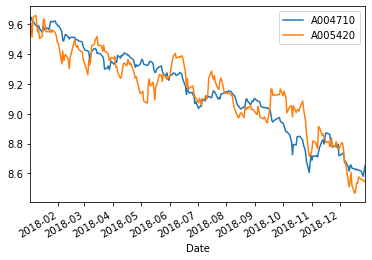

48th
0_1
0.01008055317818001
Ap: 7.95396964656695e-79
Bp: 3.045934229501103e-09
R2: 0.13546401712856326


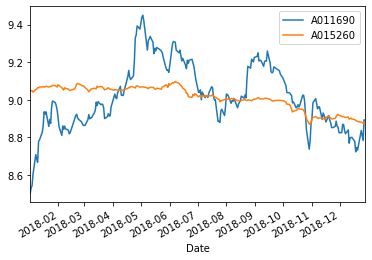

49th
0_1
0.01076257460923199
Ap: 2.4321986419471917e-95
Bp: 4.7771720769623725e-74
R2: 0.7463777511296412


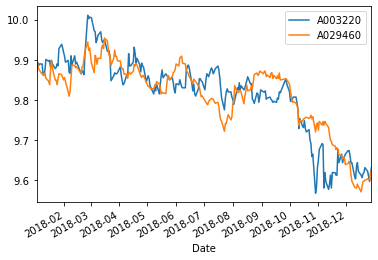

50th
0_1
0.010772354154336706
Ap: 5.450152492257427e-48
Bp: 4.048231608628248e-47
R2: 0.577061147524764


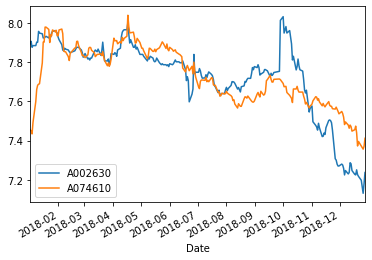

51th
0_1
0.010840285554547316
Ap: 0.292512192660733
Bp: 1.0015516166147527e-78
R2: 0.7679547544901167


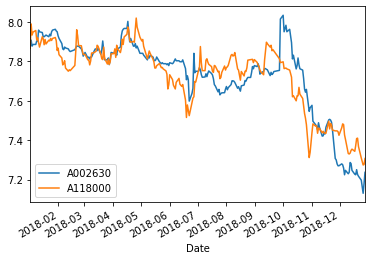

52th
0_1
0.010923468981561225
Ap: 1.4237316100559698e-32
Bp: 3.142716143828298e-06
R2: 0.08603857136392423


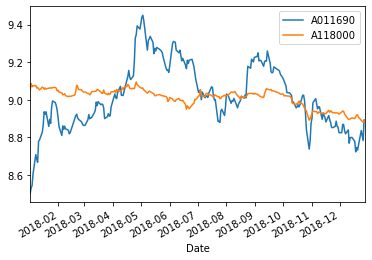

53th
0_1
0.01116924080115058
Ap: 2.0304367204854826e-28
Bp: 8.522387945408106e-94
R2: 0.82575705845949


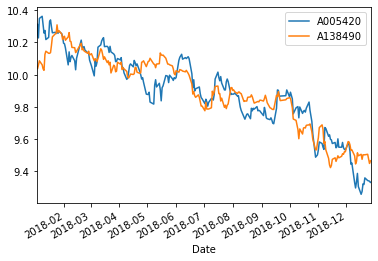

54th
0_1
0.01124547456559135
Ap: 4.6037631737237937e-10
Bp: 7.26512486156278e-55
R2: 0.6348847653309951


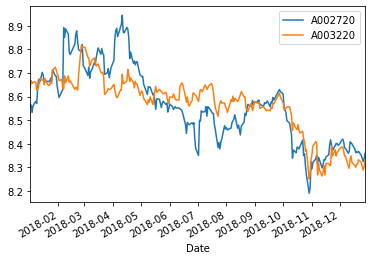

55th
0_1
0.011393141142693842
Ap: 9.744769934577212e-90
Bp: 4.137636432768767e-50
R2: 0.6003933063024137


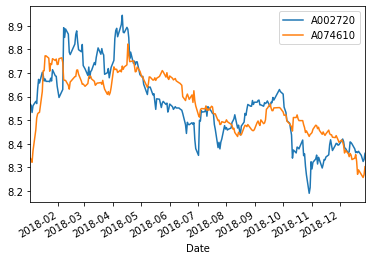

56th
0_1
0.012086892789481121
Ap: 1.6661536279237305e-47
Bp: 3.3267596431221633e-44
R2: 0.5530168116315362


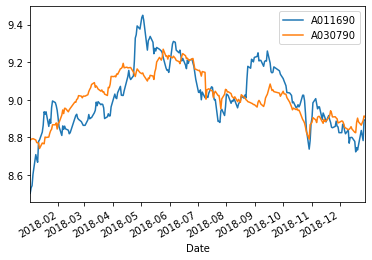

57th
0_1
0.012121007556612105
Ap: 4.1291445235578624e-101
Bp: 6.4463735265420245e-31
R2: 0.42503816431888064


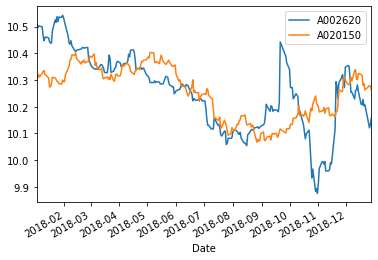

58th
0_1
0.012517815295785472
Ap: 4.2071842131478684e-77
Bp: 6.616997147860575e-64
R2: 0.6924835606250739


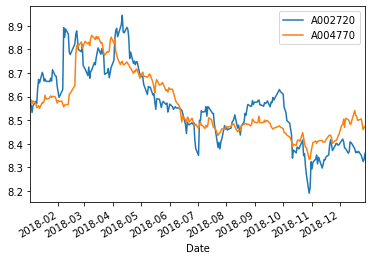

59th
0_1
0.013162641115878334
Ap: 1.7501896719502083e-31
Bp: 2.130455086786572e-14
R2: 0.21482103690656118


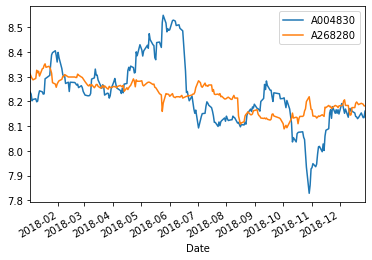

60th
0_1
0.013812633329440624
Ap: 1.9415709946352077e-57
Bp: 9.523538414281363e-66
R2: 0.7030569192055134


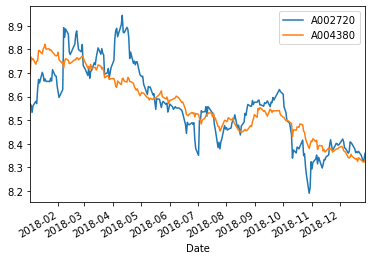

61th
0_1
0.014369936499605173
Ap: 3.955870067714583e-62
Bp: 4.3339481348037244e-59
R2: 0.6630272691174093


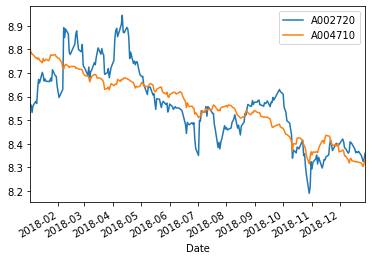

62th
0_1
0.014779676762441426
Ap: 0.005946996654899343
Bp: 1.2801383498999936e-78
R2: 0.7674842147141789


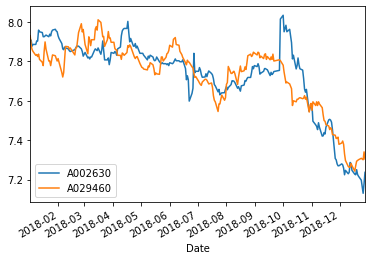

63th
0_1
0.015171027322957817
Ap: 8.548806156163344e-63
Bp: 9.146700724766545e-87
R2: 0.8008383382091533


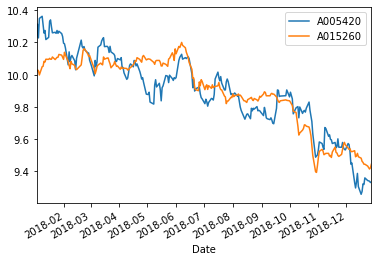

64th
0_1
0.01720853585833199
Ap: 0.0068135703877940015
Bp: 1.2258103715292464e-52
R2: 0.6191167694863104


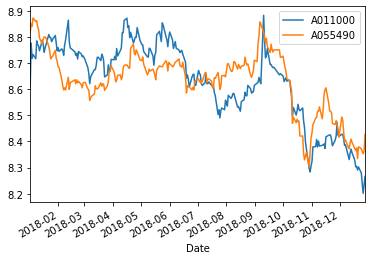

65th
0_1
0.017751055892257044
Ap: 8.004900067744928e-30
Bp: 6.046817892924291e-103
R2: 0.853579383654772


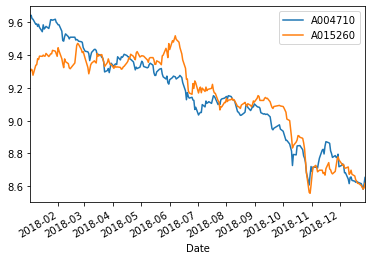

66th
0_1
0.017868049821640638
Ap: 1.3460968410478306e-08
Bp: 1.4074667682354526e-48
R2: 0.5886076415337294


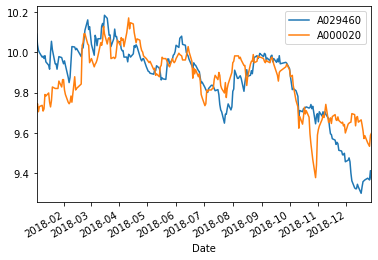

67th
0_1
0.01907162637703064
Ap: 3.857586220887669e-167
Bp: 6.0394300926697256e-46
R2: 0.5675375619058548


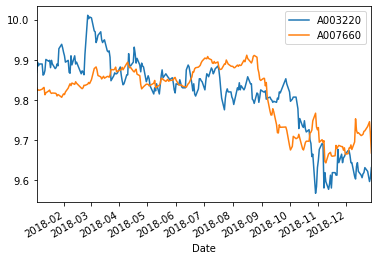

68th
0_1
0.019445869210828876
Ap: 2.9596346851543533e-45
Bp: 8.725440883354071e-72
R2: 0.7352404036363375


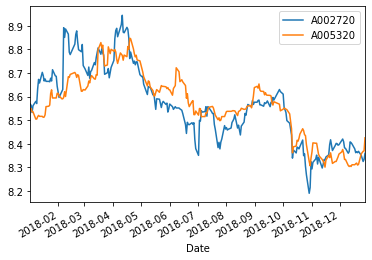

69th
0_0
2.7226376316965443e-05
Ap: 1.5148413911174619e-33
Bp: 2.1358918769396355e-116
R2: 0.8866303917971571


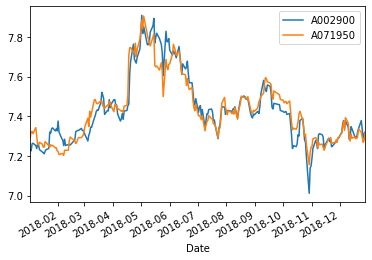

70th
0_0
0.0005256150079969656
Ap: 1.854311078042507e-124
Bp: 8.895400724924851e-70
R2: 0.7249416436372903


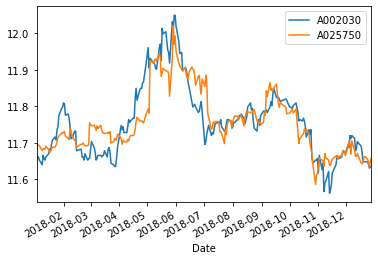

71th
0_0
0.0016259306751391124
Ap: 4.511064888578504e-07
Bp: 5.452875701025033e-86
R2: 0.7978810130016192


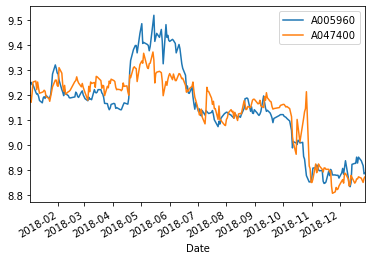

72th
0_0
0.002567663594875262
Ap: 1.4944092199467838e-49
Bp: 1.3570553295151578e-124
R2: 0.9029969208309435


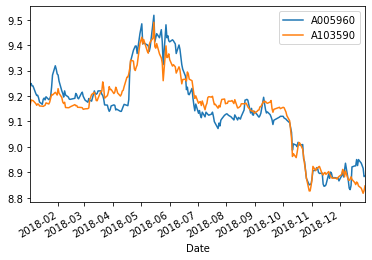

73th
0_0
0.0031937310562457186
Ap: 6.91179116175107e-119
Bp: 9.285422506889869e-64
R2: 0.6916228639352175


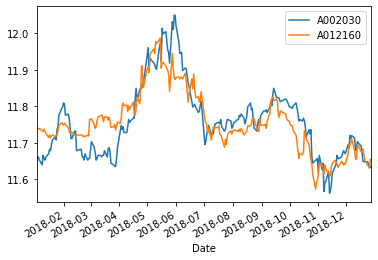

74th
0_0
0.0035794081887330405
Ap: 2.5292331641402608e-139
Bp: 1.7774594983834127e-69
R2: 0.723365996039393


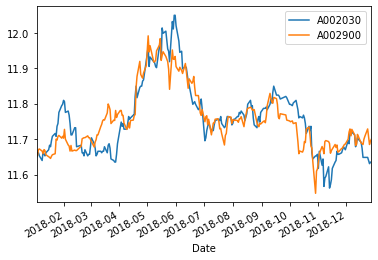

75th
0_0
0.004443893555978699
Ap: 0.001620509337939591
Bp: 3.4184075900639672e-77
R2: 0.7610938078960842


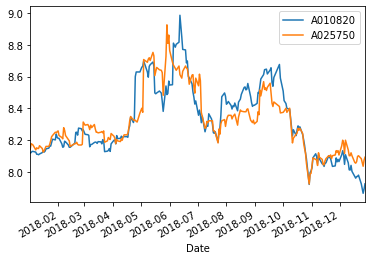

76th
0_0
0.0048678360849299974
Ap: 1.206861480588553e-105
Bp: 2.9499590639319833e-16
R2: 0.24174960135557233


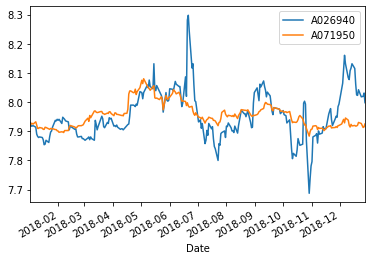

77th
0_0
0.005959292939009571
Ap: 2.189992480753459e-20
Bp: 7.348887202650658e-71
R2: 0.7305435687733437


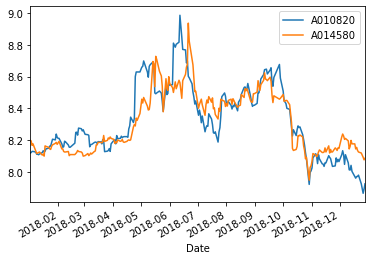

78th
0_0
0.006943363047139787
Ap: 7.223233057914125e-42
Bp: 4.234922147209585e-75
R2: 0.7513992999894403


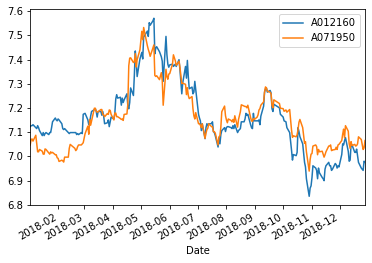

79th
0_0
0.008370035757908819
Ap: 2.1961498171327004e-111
Bp: 0.39927530299923386
R2: 0.002937729676687484


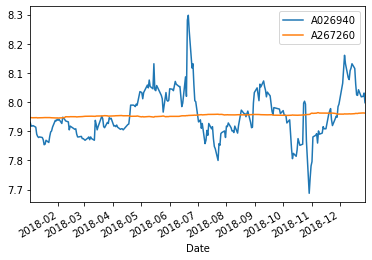

80th
0_0
0.010011817143428836
Ap: 3.291484526214236e-72
Bp: 0.4653386301380579
R2: 0.002204695707220372


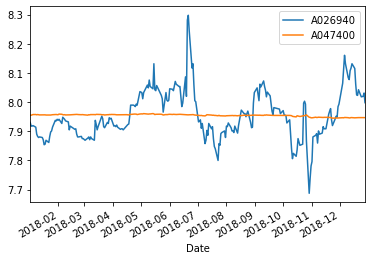

81th
0_0
0.011057940215266638
Ap: 4.483350336573334e-148
Bp: 1.8845267449072103e-53
R2: 0.6249513284875416


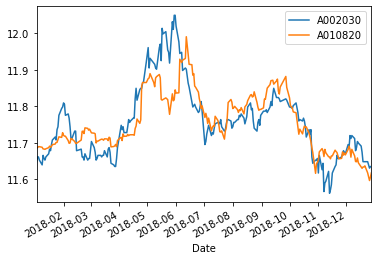

82th
0_0
0.011424687730582231
Ap: 2.782562378244933e-88
Bp: 0.003660592086417715
R2: 0.03436410547606461


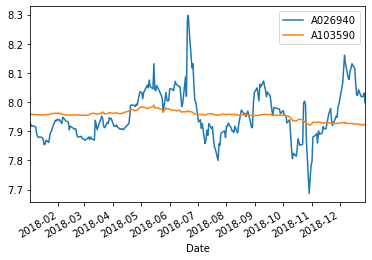

83th
0_0
0.012743503514465536
Ap: 4.874304354887832e-20
Bp: 4.430986163631058e-52
R2: 0.6150605530950013


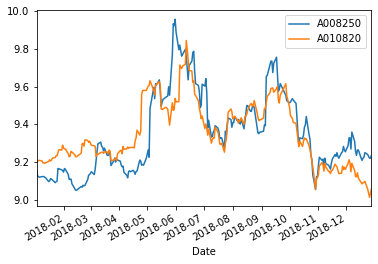

84th
0_0
0.01474552249674152
Ap: 1.7301990961585694e-34
Bp: 2.1372142302332425e-12
R2: 0.1848277751743157


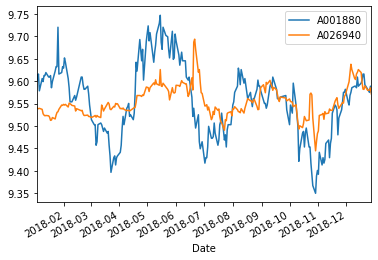

85th
1_1
0.00013504037609206478
Ap: 8.151346256875417e-66
Bp: 2.174835823168736e-71
R2: 0.7332374390430891


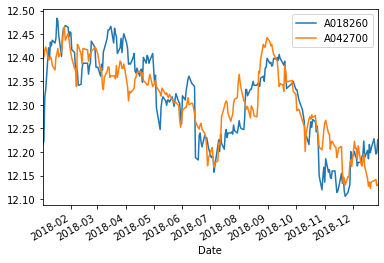

86th
1_1
0.0005254012156395056
Ap: 3.972921044318798e-36
Bp: 1.4611504314961942e-66
R2: 0.7076140202255422


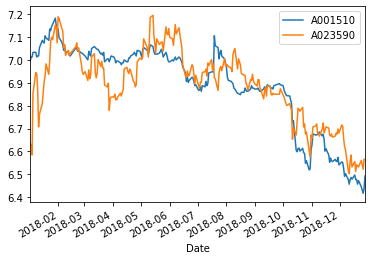

87th
1_1
0.0011560966623831504
Ap: 1.8948660725751468e-28
Bp: 5.2577016763121836e-45
R2: 0.559758559318787


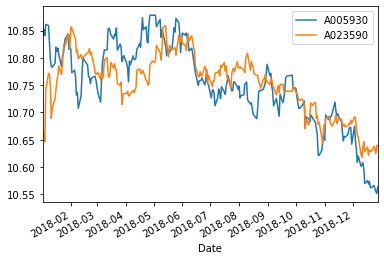

88th
1_1
0.0031014636496103404
Ap: 0.00011753386878651425
Bp: 2.0831869516882546e-43
R2: 0.546211331078431


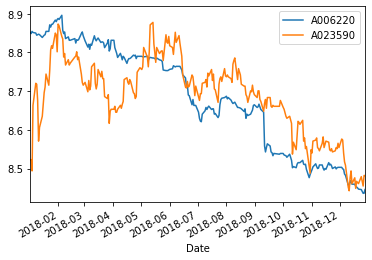

89th
1_1
0.005967328582874383
Ap: 8.547342081790513e-19
Bp: 1.8028771530056348e-44
R2: 0.5552667854930295


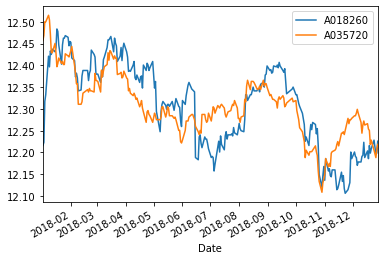

90th
1_1
0.007781238296983079
Ap: 1.8265021282506892e-73
Bp: 1.407723215152052e-66
R2: 0.7077038672168756


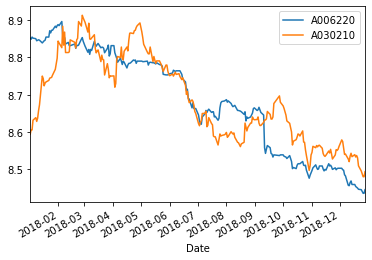

91th
1_1
0.011003565152887718
Ap: 1.984145803641187e-57
Bp: 1.061260763872863e-82
R2: 0.7848401237783671


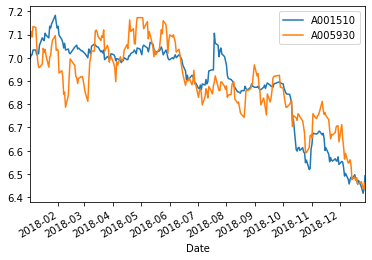

92th
1_1
0.013468312762925296
Ap: 4.4436970492591905e-44
Bp: 6.970048883484902e-24
R2: 0.3432575736764506


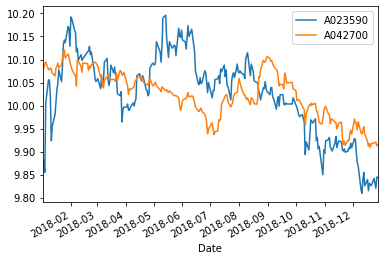

93th
1_1
0.015017664840338415
Ap: 3.426874704631512e-39
Bp: 6.149114840812523e-38
R2: 0.4966236615219254


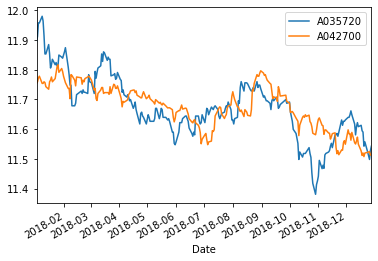

94th
1_1
0.01975113572874005
Ap: 6.943554901507105e-46
Bp: 1.3922836240448717e-32
R2: 0.44288316999338817


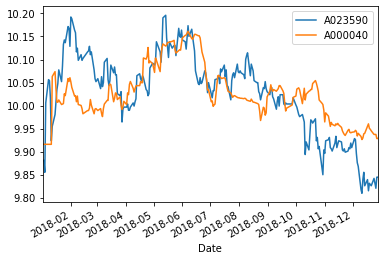

95th
1_0
0.0017368499226227661
Ap: 2.441477262707608e-14
Bp: 9.036161047670924e-73
R2: 0.7401488469486387


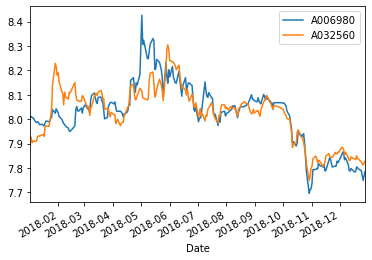

96th
1_0
0.0028427164293672444
Ap: 5.001634468344999e-17
Bp: 7.562911778232844e-85
R2: 0.7934449816433538


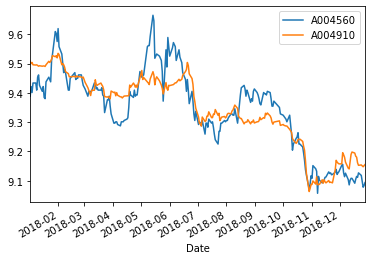

97th
1_0
0.0032879128309774457
Ap: 1.7144183222083377e-105
Bp: 2.807321462502597e-43
R2: 0.5450948999831315


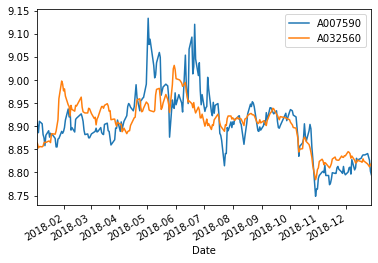

98th
1_0
0.0069944761875477745
Ap: 1.2567710498912291e-18
Bp: 3.077775494678316e-75
R2: 0.7520532804197759


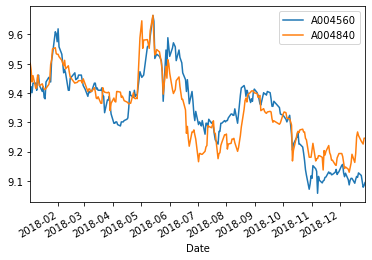

99th
1_0
0.008882456293182683
Ap: 8.278222103702955e-25
Bp: 4.2248435069821746e-83
R2: 0.7864699066581072


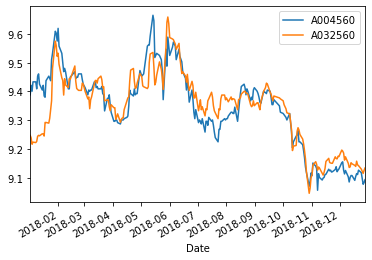

100th
1_0
0.010733707519599097
Ap: 3.3628162329846756e-06
Bp: 1.7134278220402352e-57
R2: 0.6526518415334337


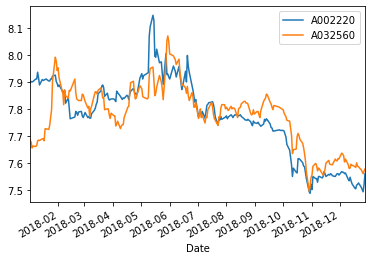

101th
1_0
0.01138408633055303
Ap: 6.028472035592287e-91
Bp: 4.2187135499488915e-56
R2: 0.6433534429971278


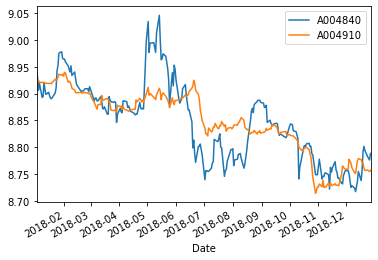

102th
1_0
0.01140677902933797
Ap: 5.206211909714867e-12
Bp: 1.3562740971446213e-47
R2: 0.5808550505812069


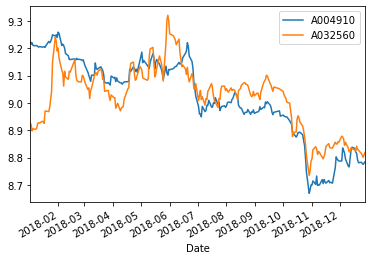

103th
1_0
0.011506766078383565
Ap: 0.012154660265297127
Bp: 2.840671558868551e-79
R2: 0.7703558054651162


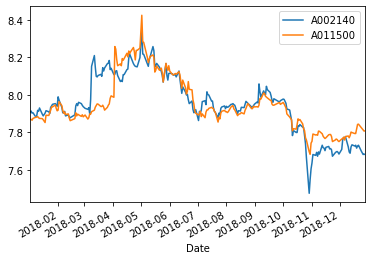

104th
1_0
0.012536100895614178
Ap: 0.0013070191350132044
Bp: 1.7090335355251052e-87
R2: 0.8035775919135021


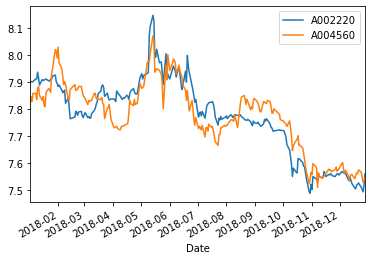

105th
1_0
0.01685742340575136
Ap: 2.769279889417666e-29
Bp: 4.617624420737228e-77
R2: 0.7605001111000257


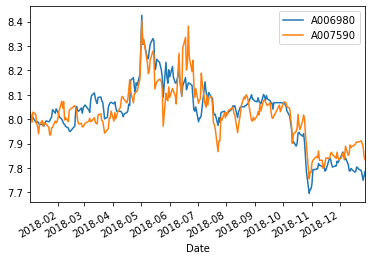

106th
1_2
0.007697469026088131
Ap: 0.0036740004105398354
Bp: 1.4629387456814477e-118
R2: 0.8912025852786892


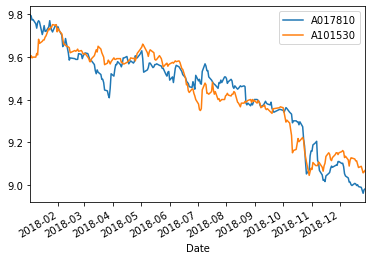

In [244]:
draw_pairs(df_pairs_t)

In [241]:
df_pairs_t = finding_pairs(df_price)
df_pairs_t

C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Finding Pairs from 0 Cluster(74 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster


C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_launcher.py:92: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 1 Cluster(26 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster


alpha     ap    beta     bp cluster   pval     r2       s1       s2
0   -0.3888 0.0063  0.9156 0.0000     0_2 0.0011 0.9580  A026960  A072710
1   15.2004 0.0000 -0.3496 0.0000     0_2 0.0013 0.3518  A000210  A071840
2   13.9623 0.0000 -0.2631 0.0000     0_2 0.0018 0.2622  A000210  A026960
3   13.0923 0.0000 -0.1775 0.0000     0_2 0.0023 0.1765  A000210  A001120
4   -0.7224 0.0007  1.1606 0.0000     0_2 0.0034 0.9271  A004000  A026960
..      ...    ...     ...    ...     ...    ...    ...      ...      ...
102  2.5604 0.0000  0.6979 0.0000     1_0 0.0114 0.5809  A004910  A032560
103 -0.7731 0.0122  1.0345 0.0000     1_0 0.0115 0.7704  A002140  A011500
104 -0.8962 0.0013  0.9280 0.0000     1_0 0.0125 0.8036  A002220  A004560
105 -6.9653 0.0000  1.6827 0.0000     1_0 0.0169 0.7605  A006980  A007590
106 -0.6657 0.0037  1.0653 0.0000     1_2 0.0077 0.8912  A017810  A101530

[107 rows x 9 columns]

In [177]:
ticker_series = pd.read_pickle("./kse_18_20_ticker.pkl")
ticker_series

A005930        삼성전자
A000660      SK하이닉스
A207940    삼성바이오로직스
A035420       NAVER
A068270        셀트리온
             ...   
A005030        부산주공
A019490        하이트론
A109070         컨버즈
A025890        한국주강
A008500        일정실업
Name: 0, Length: 776, dtype: object

In [17]:
sector_df = pd.read_pickle("./kse_sector.pkl")
sector_df

A005930                       A000660  \
세세분류                통신 및 방송 장비 제조업    다이오드, 트랜지스터 및 유사 반도체소자 제조업   
세분류                 통신 및 방송 장비 제조업    다이오드, 트랜지스터 및 유사 반도체소자 제조업   
소분류                 통신 및 방송 장비 제조업                       반도체 제조업   
중분류   전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업  전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업   
대분류                           제조업                           제조업    

                    A207940                           A035420  \
세세분류            생물학적 제제 제조업             포털 및 기타 인터넷 정보매개 서비스업   
세분류   기초 의약물질 및 생물학적 제제 제조업             포털 및 기타 인터넷 정보매개 서비스업   
소분류   기초 의약물질 및 생물학적 제제 제조업  자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업   
중분류        의료용 물질 및 의약품 제조업                            정보서비스업   
대분류                    제조업             출판, 영상, 방송통신 및 정보서비스업    

                    A068270                  A051910                  A051900  \
세세분류            생물학적 제제 제조업        석유화학계 기초 화학물질 제조업       치약, 비누 및 기타 세제 제조업   
세분류   기초 의약물질 및 생물학적 제제 제조업           기초 유기 화학물질 제조업        세제, 화장품 및 광택제 제조업   
소분류   기초 의약물질 및 생물학적 제제 제조업              기초 화학물질 제조업              기타 화학제품 제조업   
중분류        의료용 물질 및 의약품 제조업  화학물질 및 화학제품 제조업; 의약품 제외  화학물질 및 화학제품 제조업; 의약품 제외   
대분류                    제조업                      제조업                      제조업    

                   A005380         A006400      A028260  ...          A012600  \
세세분류  승용차 및 기타 여객용 자동차 제조업         축전지 제조업    기타 전문 도매업  ...  사무용 기계 및 장비 제조업   
세분류                자동차 제조업  일차전지 및 축전지 제조업    기타 전문 도매업  ...  사무용 기계 및 장비 제조업   
소분류      자동차용 엔진 및 자동차 제조업  일차전지 및 축전지 제조업    기타 전문 도매업  ...    일반 목적용 기계 제조업   
중분류         자동차 및 트레일러 제조업        전기장비 제조업  도매 및 상품 중개업  ...   기타 기계 및 장비 제조업   
대분류                   제조업             제조업     도매 및 소매업   ...             제조업    

                           A015260         A000950                    A002420  \
세세분류               인쇄회로기판용 적층판 제조업           면 방적업                    영화관 운영업   
세분류         인쇄회로기판 및 전자부품 실장기판 제조업    방적 및 가공사 제조업              영화 및 비디오물 상영업   
소분류                       전자부품 제조업    방적 및 가공사 제조업  영화, 비디오물, 방송프로그램 제작 및 배급업   
중분류   전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업  섬유제품 제조업; 의복제외        영상ㆍ오디오 기록물 제작 및 배급업   
대분류                           제조업             제조업      출판, 영상, 방송통신 및 정보서비스업    

                A010580                       A019490            A005030  \
세세분류  자동차 엔진용 신품 부품 제조업                 영상 및 음향기기 제조업  자동차 엔진용 신품 부품 제조업   
세분류   자동차 엔진용 신품 부품 제조업                 영상 및 음향기기 제조업  자동차 엔진용 신품 부품 제조업   
소분류       자동차 신품 부품 제조업                 영상 및 음향기기 제조업      자동차 신품 부품 제조업   
중분류      자동차 및 트레일러 제조업  전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업     자동차 및 트레일러 제조업   
대분류                제조업                           제조업                제조업    

             A025890                 A109070         A008500  
세세분류   특수 목적용 기계 제조업  골판지, 종이 상자 및 종이 용기 제조업        편조원단 제조업  
세분류    특수 목적용 기계 제조업  골판지, 종이 상자 및 종이 용기 제조업        편조원단 제조업  
소분류    특수 목적용 기계 제조업  골판지, 종이 상자 및 종이 용기 제조업        편조원단 제조업  
중분류   기타 기계 및 장비 제조업       펄프, 종이 및 종이제품 제조업  섬유제품 제조업; 의복제외  
대분류             제조업                     제조업             제조업   

[5 rows x 777 columns]

In [18]:
df = pd.read_pickle("./kse_18_20.pkl")
end_date = datetime.datetime(2018, 12, 31)
target_date = df.index < end_date
df = df.loc[target_date, :]
df

Item          수정주가(원)                                                         \
Symbol        A000020   A000040    A000050    A000060     A000070    A000080   
Date                                                                           
2018-01-02  9870.0000 1985.0000 13850.0000 23350.0000 121500.0000 24400.0000   
2018-01-03 10000.0000 1985.0000 13750.0000 23350.0000 123500.0000 24800.0000   
2018-01-04  9750.0000 1985.0000 13750.0000 22700.0000 122000.0000 24550.0000   
2018-01-05  9910.0000 1985.0000 13550.0000 23250.0000 129500.0000 24400.0000   
2018-01-08  9950.0000 1985.0000 13450.0000 23000.0000 129000.0000 23850.0000   
...               ...       ...        ...        ...         ...        ...   
2018-12-21  9030.0000 2091.0000 10950.0000 21900.0000  81200.0000 18000.0000   
2018-12-24  8830.0000 2062.0000 11100.0000 21700.0000  80400.0000 17750.0000   
2018-12-26  8730.0000 2062.0000 10850.0000 21950.0000  79000.0000 17550.0000   
2018-12-27  9040.0000 2030.0000 10900.0000 21550.0000  77600.0000 16950.0000   
2018-12-28  9100.0000 2030.0000 10800.0000 21850.0000  78500.0000 16600.0000   

Item                                                     ...  \
Symbol        A000100     A000120    A000140    A000150  ...   
Date                                                     ...   
2018-01-02 39758.0000 144000.0000 10000.0000 89408.0000  ...   
2018-01-03 39483.0000 145000.0000 10200.0000 90590.0000  ...   
2018-01-04 38933.0000 145000.0000  9970.0000 93741.0000  ...   
2018-01-05 39849.0000 141500.0000 10050.0000 92559.0000  ...   
2018-01-08 39391.0000 139000.0000 10000.0000 90590.0000  ...   
...               ...         ...        ...        ...  ...   
2018-12-21 40216.0000 170500.0000  7000.0000 94528.0000  ...   
2018-12-24 40307.0000 167000.0000  7100.0000 90983.0000  ...   
2018-12-26 40399.0000 165000.0000  6920.0000 87439.0000  ...   
2018-12-27 39346.0000 168500.0000  6940.0000 86257.0000  ...   
2018-12-28 39154.0000 167000.0000  7010.0000 87833.0000  ...   

Item       시가총액 (52주 평균)(백만원)                                              \
Symbol                A300720     A306200 A307950 A308170 A316140 A317400   
Date                                                                        
2018-01-02                nan         nan     nan     nan     nan     nan   
2018-01-03                nan         nan     nan     nan     nan     nan   
2018-01-04                nan         nan     nan     nan     nan     nan   
2018-01-05                nan         nan     nan     nan     nan     nan   
2018-01-08                nan         nan     nan     nan     nan     nan   
...                       ...         ...     ...     ...     ...     ...   
2018-12-21        551083.0000 175907.0000     nan     nan     nan     nan   
2018-12-24        550496.0000 175638.0000     nan     nan     nan     nan   
2018-12-26        549856.0000 175328.0000     nan     nan     nan     nan   
2018-12-27        549102.0000 175102.0000     nan     nan     nan     nan   
2018-12-28        548468.0000 174875.0000     nan     nan     nan     nan   

Item                                        
Symbol     A322000 A336260 A336370 A344820  
Date                                        
2018-01-02     nan     nan     nan     nan  
2018-01-03     nan     nan     nan     nan  
2018-01-04     nan     nan     nan     nan  
2018-01-05     nan     nan     nan     nan  
2018-01-08     nan     nan     nan     nan  
...            ...     ...     ...     ...  
2018-12-21     nan     nan     nan     nan  
2018-12-24     nan     nan     nan     nan  
2018-12-26     nan     nan     nan     nan  
2018-12-27     nan     nan     nan     nan  
2018-12-28     nan     nan     nan     nan  

[244 rows x 1552 columns]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2018-01-02 to 2018-12-28
Columns: 1552 entries, (수정주가(원), A000020) to (시가총액 (52주 평균)(백만원), A344820)
dtypes: float64(1552)
memory usage: 2.9 MB


In [20]:
df.describe()

Item      수정주가(원)                                                         \
Symbol    A000020   A000040    A000050    A000060     A000070    A000080   
count    244.0000  244.0000   244.0000   244.0000    244.0000   244.0000   
mean   10800.0820 2416.9795 13257.9918 20566.1885 104332.3770 19394.2623   
std     1058.7126  263.6880  1235.1703  1905.0815  13613.2310  2562.1509   
min     7900.0000 1985.0000 10400.0000 17650.0000  73600.0000 15300.0000   
25%     9907.5000 2264.0000 12850.0000 18750.0000  94700.0000 17000.0000   
50%    10950.0000 2379.0000 13575.0000 20450.0000 105000.0000 19125.0000   
75%    11550.0000 2517.0000 14062.5000 21800.0000 114500.0000 21512.5000   
max    13150.0000 3069.0000 15900.0000 25300.0000 145500.0000 24900.0000   

Item                                                  ... 시가총액 (52주 평균)(백만원)  \
Symbol    A000100     A000120    A000140     A000150  ...            A300720   
count    244.0000    244.0000   244.0000    244.0000  ...            98.0000   
mean   41167.6352 150864.7541  8633.5246  89851.9262  ...        559285.6837   
std     2413.9079  12105.5945  1122.0087   8700.6838  ...         28805.7833   
min    30688.0000 122000.0000  6460.0000  75150.0000  ...        493251.0000   
25%    39574.0000 140500.0000  7880.0000  82712.0000  ...        550642.7500   
50%    41132.0000 152500.0000  8575.0000  88817.0000  ...        564452.0000   
75%    42872.0000 159000.0000  9610.0000  95316.0000  ...        583009.2500   
max    47178.0000 175000.0000 10500.0000 112646.0000  ...        592579.0000   

Item                                                                        \
Symbol     A306200 A307950 A308170 A316140 A317400 A322000 A336260 A336370   
count      59.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
mean   183060.1525     nan     nan     nan     nan     nan     nan     nan   
std      7820.0055     nan     nan     nan     nan     nan     nan     nan   
min    174875.0000     nan     nan     nan     nan     nan     nan     nan   
25%    177422.5000     nan     nan     nan     nan     nan     nan     nan   
50%    179188.0000     nan     nan     nan     nan     nan     nan     nan   
75%    188773.0000     nan     nan     nan     nan     nan     nan     nan   
max    207050.0000     nan     nan     nan     nan     nan     nan     nan   

Item            
Symbol A344820  
count   0.0000  
mean       nan  
std        nan  
min        nan  
25%        nan  
50%        nan  
75%        nan  
max        nan  

[8 rows x 1552 columns]

In [21]:
df = df.dropna(axis=1)
df

Item          수정주가(원)                                                         \
Symbol        A000020   A000040    A000050    A000060     A000070    A000080   
Date                                                                           
2018-01-02  9870.0000 1985.0000 13850.0000 23350.0000 121500.0000 24400.0000   
2018-01-03 10000.0000 1985.0000 13750.0000 23350.0000 123500.0000 24800.0000   
2018-01-04  9750.0000 1985.0000 13750.0000 22700.0000 122000.0000 24550.0000   
2018-01-05  9910.0000 1985.0000 13550.0000 23250.0000 129500.0000 24400.0000   
2018-01-08  9950.0000 1985.0000 13450.0000 23000.0000 129000.0000 23850.0000   
...               ...       ...        ...        ...         ...        ...   
2018-12-21  9030.0000 2091.0000 10950.0000 21900.0000  81200.0000 18000.0000   
2018-12-24  8830.0000 2062.0000 11100.0000 21700.0000  80400.0000 17750.0000   
2018-12-26  8730.0000 2062.0000 10850.0000 21950.0000  79000.0000 17550.0000   
2018-12-27  9040.0000 2030.0000 10900.0000 21550.0000  77600.0000 16950.0000   
2018-12-28  9100.0000 2030.0000 10800.0000 21850.0000  78500.0000 16600.0000   

Item                                                     ...  \
Symbol        A000100     A000120    A000140    A000150  ...   
Date                                                     ...   
2018-01-02 39758.0000 144000.0000 10000.0000 89408.0000  ...   
2018-01-03 39483.0000 145000.0000 10200.0000 90590.0000  ...   
2018-01-04 38933.0000 145000.0000  9970.0000 93741.0000  ...   
2018-01-05 39849.0000 141500.0000 10050.0000 92559.0000  ...   
2018-01-08 39391.0000 139000.0000 10000.0000 90590.0000  ...   
...               ...         ...        ...        ...  ...   
2018-12-21 40216.0000 170500.0000  7000.0000 94528.0000  ...   
2018-12-24 40307.0000 167000.0000  7100.0000 90983.0000  ...   
2018-12-26 40399.0000 165000.0000  6920.0000 87439.0000  ...   
2018-12-27 39346.0000 168500.0000  6940.0000 86257.0000  ...   
2018-12-28 39154.0000 167000.0000  7010.0000 87833.0000  ...   

Item       시가총액 (52주 평균)(백만원)                                       \
Symbol                A267290     A268280      A271560     A271980   
Date                                                                 
2018-01-02        163383.0000 308852.0000 3945008.0000 659044.0000   
2018-01-03        163424.0000 308799.0000 3946407.0000 659310.0000   
2018-01-04        163466.0000 308761.0000 3946794.0000 659562.0000   
2018-01-05        163510.0000 308734.0000 3947338.0000 659929.0000   
2018-01-08        163552.0000 308697.0000 3948360.0000 660280.0000   
...                       ...         ...          ...         ...   
2018-12-21        193805.0000 323591.0000 4692495.0000 635243.0000   
2018-12-24        193766.0000 323712.0000 4693144.0000 635357.0000   
2018-12-26        193710.0000 323840.0000 4694197.0000 635326.0000   
2018-12-27        193646.0000 323995.0000 4695656.0000 635400.0000   
2018-12-28        193587.0000 324138.0000 4698167.0000 635535.0000   

Item                                                                     \
Symbol         A272450     A272550     A280360     A281820      A282330   
Date                                                                      
2018-01-02 806800.0000 299213.0000 667430.0000 449747.0000 3877932.0000   
2018-01-03 808406.0000 299518.0000 666768.0000 447743.0000 3854311.0000   
2018-01-04 809559.0000 300004.0000 666273.0000 445443.0000 3831435.0000   
2018-01-05 810833.0000 300623.0000 665755.0000 443551.0000 3810621.0000   
2018-01-08 811105.0000 300865.0000 665170.0000 441380.0000 3791088.0000   
...                ...         ...         ...         ...          ...   
2018-12-21 775285.0000 268912.0000 709872.0000 357131.0000 3212859.0000   
2018-12-24 774326.0000 268757.0000 710113.0000 356076.0000 3212221.0000   
2018-12-26 773305.0000 268586.0000 710234.0000 355062.0000 3211583.0000   
2018-12-27 772359.0000 268411.0000 710381.0000 354072.0000 3210911.0000   
2018-12-28 771467.0000 268

In [22]:
df_price = df['수정주가(원)']
df_price

Symbol        A000020   A000040    A000050    A000060     A000070    A000080  \
Date                                                                           
2018-01-02  9870.0000 1985.0000 13850.0000 23350.0000 121500.0000 24400.0000   
2018-01-03 10000.0000 1985.0000 13750.0000 23350.0000 123500.0000 24800.0000   
2018-01-04  9750.0000 1985.0000 13750.0000 22700.0000 122000.0000 24550.0000   
2018-01-05  9910.0000 1985.0000 13550.0000 23250.0000 129500.0000 24400.0000   
2018-01-08  9950.0000 1985.0000 13450.0000 23000.0000 129000.0000 23850.0000   
...               ...       ...        ...        ...         ...        ...   
2018-12-21  9030.0000 2091.0000 10950.0000 21900.0000  81200.0000 18000.0000   
2018-12-24  8830.0000 2062.0000 11100.0000 21700.0000  80400.0000 17750.0000   
2018-12-26  8730.0000 2062.0000 10850.0000 21950.0000  79000.0000 17550.0000   
2018-12-27  9040.0000 2030.0000 10900.0000 21550.0000  77600.0000 16950.0000   
2018-12-28  9100.0000 2030.0000 10800.0000 21850.0000  78500.0000 16600.0000   

Symbol        A000100     A000120    A000140    A000150  ...    A267290  \
Date                                                     ...              
2018-01-02 39758.0000 144000.0000 10000.0000 89408.0000  ... 28587.0000   
2018-01-03 39483.0000 145000.0000 10200.0000 90590.0000  ... 28827.0000   
2018-01-04 38933.0000 145000.0000  9970.0000 93741.0000  ... 28867.0000   
2018-01-05 39849.0000 141500.0000 10050.0000 92559.0000  ... 28947.0000   
2018-01-08 39391.0000 139000.0000 10000.0000 90590.0000  ... 28907.0000   
...               ...         ...        ...        ...  ...        ...   
2018-12-21 40216.0000 170500.0000  7000.0000 94528.0000  ... 26785.0000   
2018-12-24 40307.0000 167000.0000  7100.0000 90983.0000  ... 26985.0000   
2018-12-26 40399.0000 165000.0000  6920.0000 87439.0000  ... 26705.0000   
2018-12-27 39346.0000 168500.0000  6940.0000 86257.0000  ... 26345.0000   
2018-12-28 39154.0000 167000.0000  7010.0000 87833.0000  ... 26585.0000   

Symbol        A268280     A271560    A271980    A272450    A272550  \
Date                                                                 
2018-01-02 57600.0000 107000.0000 46522.0000 27650.0000 20450.0000   
2018-01-03 58100.0000 104000.0000 46879.0000 27750.0000 21550.0000   
2018-01-04 58500.0000 101000.0000 46808.0000 27600.0000 21900.0000   
2018-01-05 58800.0000 101500.0000 47737.0000 27750.0000 22200.0000   
2018-01-08 58500.0000 103000.0000 47666.0000 27200.0000 21600.0000   
...               ...         ...        ...        ...        ...   
2018-12-21 64300.0000 117500.0000 44400.0000 19400.0000 17350.0000   
2018-12-24 64000.0000 117500.0000 44250.0000 18950.0000 17450.0000   
2018-12-26 64200.0000 115000.0000 42200.0000 18500.0000 16950.0000   
2018-12-27 64600.0000 114000.0000 43950.0000 18750.0000 17000.0000   
2018-12-28 64600.0000 120000.0000 46600.0000 19250.0000 16800.0000   

Symbol         A280360    A281820     A282330    A282690  
Date                                                      
2018-01-02 147000.0000 20700.0000 210500.0000 10300.0000  
2018-01-03 151500.0000 20750.0000 202500.0000 11150.0000  
2018-01-04 153000.0000 20250.0000 200500.0000 11150.0000  
2018-01-05 152500.0000 20450.0000 200000.0000 11150.0000  
2018-01-08 151500.0000 19950.0000 199000.0000 10900.0000  
...                ...        ...         ...        ...  
2018-12-21 162500.0000  9330.0000 218000.0000 12850.0000  
2018-12-24 159500.0000  9470.0000 210500.0000 12900.0000  
2018-12-26 156000.0000  9290.0000 210000.0000 12500.0000  
2018-12-27 156000.0000  9420.0000 203000.0000 12850.0000  
2018-12-28 151000.0000  9490.0000 204000.0000 12700.0000  

[244 rows x 750 columns]

## PCA 분석

### Normalization return process

In [23]:
df_return = df_price.pct_change()
df_return = df_return.dropna(axis=0)
df_return

Symbol      A000020  A000040  A000050  A000060  A000070  A000080  A000100  \
Date                                                                        
2018-01-03   0.0132   0.0000  -0.0072   0.0000   0.0165   0.0164  -0.0069   
2018-01-04  -0.0250   0.0000   0.0000  -0.0278  -0.0121  -0.0101  -0.0139   
2018-01-05   0.0164   0.0000  -0.0145   0.0242   0.0615  -0.0061   0.0235   
2018-01-08   0.0040   0.0000  -0.0074  -0.0108  -0.0039  -0.0225  -0.0115   
2018-01-09  -0.0181   0.0000   0.0112   0.0065  -0.0039   0.0273   0.0256   
...             ...      ...      ...      ...      ...      ...      ...   
2018-12-21   0.0089  -0.0057  -0.0045   0.0046  -0.0193  -0.0110   0.0162   
2018-12-24  -0.0221  -0.0139   0.0137  -0.0091  -0.0099  -0.0139   0.0023   
2018-12-26  -0.0113   0.0000  -0.0225   0.0115  -0.0174  -0.0113   0.0023   
2018-12-27   0.0355  -0.0155   0.0046  -0.0182  -0.0177  -0.0342  -0.0261   
2018-12-28   0.0066   0.0000  -0.0092   0.0139   0.0116  -0.0206  -0.0049   

Symbol      A000120  A000140  A000150  ...  A267290  A268280  A271560  \
Date                                   ...                              
2018-01-03   0.0069   0.0200   0.0132  ...   0.0084   0.0087  -0.0280   
2018-01-04   0.0000  -0.0225   0.0348  ...   0.0014   0.0069  -0.0288   
2018-01-05  -0.0241   0.0080  -0.0126  ...   0.0028   0.0051   0.0050   
2018-01-08  -0.0177  -0.0050  -0.0213  ...  -0.0014  -0.0051   0.0148   
2018-01-09   0.0036   0.0000   0.0348  ...  -0.0028  -0.0291   0.0340   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-21   0.0000  -0.0014   0.0084  ...  -0.0089   0.0047  -0.0042   
2018-12-24  -0.0205   0.0143  -0.0375  ...   0.0075  -0.0047   0.0000   
2018-12-26  -0.0120  -0.0254  -0.0390  ...  -0.0104   0.0031  -0.0213   
2018-12-27   0.0212   0.0029  -0.0135  ...  -0.0135   0.0062  -0.0087   
2018-12-28  -0.0089   0.0101   0.0183  ...   0.0091   0.0000   0.0526   

Symbol      A271980  A272450  A272550  A280360  A281820  A282330  A282690  
Date                                                                       
2018-01-03   0.0077   0.0036   0.0538   0.0306   0.0024  -0.0380   0.0825  
2018-01-04  -0.0015  -0.0054   0.0162   0.0099  -0.0241  -0.0099   0.0000  
2018-01-05   0.0198   0.0054   0.0137  -0.0033   0.0099  -0.0025   0.0000  
2018-01-08  -0.0015  -0.0198  -0.0270  -0.0066  -0.0244  -0.0050  -0.0224  
2018-01-09  -0.0510  -0.0092   0.0093  -0.0231   0.0201   0.0352   0.0688  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-21   0.0362   0.0026   0.0000  -0.0031   0.0021   0.0259   0.0039  
2018-12-24  -0.0034  -0.0232   0.0058  -0.0185   0.0150  -0.0344   0.0039  
2018-12-26  -0.0463  -0.0237  -0.0287  -0.0219  -0.0190  -0.0024  -0.0310  
2018-12-27   0.0415   0.0135   0.0029   0.0000   0.0140  -0.0333   0.0280  
2018-12-28   0.0603   0.0267  -0.0118  -0.0321   0.0074   0.0049  -0.0117  

[243 rows x 750 columns]

In [24]:
for col in df_return.columns:
    df_return[col] = (df_return[col] - df_return[col].mean()) / df_return[col].std()
df_return

Symbol      A000020  A000040  A000050  A000060  A000070  A000080  A000100  \
Date                                                                        
2018-01-03   0.5316  -0.0170  -0.3097   0.0071   0.6199   1.0902  -0.2490   
2018-01-04  -1.0054  -0.0170   0.0392  -1.5895  -0.3740  -0.5273  -0.4898   
2018-01-05   0.6620  -0.0170  -0.6637   1.3967   2.1840  -0.2847   0.7966   
2018-01-08   0.1637  -0.0170  -0.3174  -0.6096  -0.0862  -1.2887  -0.4061   
2018-01-09  -0.7272  -0.0170   0.5781   0.3811  -0.0867   1.7538   0.8674   
...             ...      ...      ...      ...      ...      ...      ...   
2018-12-21   0.3611  -0.2063  -0.1804   0.2702  -0.6234  -0.5828   0.5457   
2018-12-24  -0.8906  -0.4771   0.7012  -0.5167  -0.2943  -0.7600   0.0663   
2018-12-26  -0.4548  -0.0170  -1.0492   0.6678  -0.5570  -0.5998   0.0670   
2018-12-27   1.4310  -0.5318   0.2619  -1.0381  -0.5678  -2.0003  -0.9066   
2018-12-28   0.2685  -0.0170  -0.4041   0.8055   0.4510  -1.1731  -0.1790   

Symbol      A000120  A000140  A000150  ...  A267290  A268280  A271560  \
Date                                   ...                              
2018-01-03   0.2831   1.7729   0.6162  ...   0.4815   0.6759  -1.0041   
2018-01-04  -0.0390  -1.7540   1.6328  ...   0.0863   0.5267  -1.0321   
2018-01-05  -1.1586   0.7802  -0.6015  ...   0.1644   0.3808   0.1412   
2018-01-08  -0.8585  -0.2973  -1.0100  ...  -0.0699  -0.4690   0.4824   
2018-01-09   0.1279   0.1151   1.6328  ...  -0.1480  -2.4590   1.1490   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-21  -0.0390  -0.0032   0.3887  ...  -0.4928   0.3442  -0.1778   
2018-12-24  -0.9912   1.2992  -1.7752  ...   0.4292  -0.4327  -0.0307   
2018-12-26  -0.5945  -1.9864  -1.8435  ...  -0.5771   0.2144  -0.7694   
2018-12-27   0.9450   0.3546  -0.6444  ...  -0.7522   0.4724  -0.3326   
2018-12-28  -0.4519   0.9511   0.8543  ...   0.5218  -0.0452   1.7965   

Symbol      A271980  A272450  A272550  A280360  A281820  A282330  A282690  
Date                                                                       
2018-01-03   0.1907   0.1977   2.7039   1.5817   0.2072  -1.3463   3.8612  
2018-01-04  -0.0589  -0.1730   0.8375   0.5013  -0.8304  -0.3569  -0.0513  
2018-01-05   0.5214   0.2724   0.7111  -0.1856   0.4993  -0.0972  -0.0513  
2018-01-08  -0.0582  -0.7652  -1.3131  -0.3572  -0.8443  -0.1854  -1.1143  
2018-01-09  -1.4026  -0.3285   0.4905  -1.2202   0.8975   1.2277   3.2109  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-21   0.9649   0.1552   0.0302  -0.1752   0.1968   0.9008   0.1339  
2018-12-24  -0.1095  -0.9039   0.3167  -0.9782   0.7000  -1.2196   0.1332  
2018-12-26  -1.2763  -0.9265  -1.3940  -1.1598  -0.6313  -0.0931  -1.5214  
2018-12-27   1.1087   0.6042   0.1769  -0.0152   0.6604  -1.1820   1.2762  
2018-12-28   1.6202   1.1446  -0.5545  -1.6871   0.4035   0.1637  -0.6047  

[243 rows x 750 columns]

In [25]:
pca = PCA()
pca.fit(df_return)
return_pca = pca.transform(df_return)
return_pca.shape

(243, 243)

### Eigen Portfolio

In [26]:
df_return.mul(pca.components_[0]).sum(axis=1)

Date
2018-01-03   -3.5432
2018-01-04    4.7109
2018-01-05   -8.7842
2018-01-08   -0.1702
2018-01-09   -0.3383
               ...  
2018-12-21    2.1823
2018-12-24    6.2925
2018-12-26   17.5016
2018-12-27   -5.6331
2018-12-28   -9.2270
Length: 243, dtype: float64

In [27]:
print("Variance Explanation Ratio")
print("1st Eigen Vector: {:.4f}".format(pca.explained_variance_ratio_[0]))


Variance Explanation Ratio
1st Eigen Vector: 0.1842


In [28]:
eig1 = pca.components_[0] / pca.components_[0].sum()

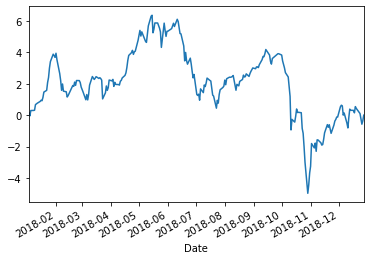

In [29]:
ep_return_df = df_return.mul(eig1, axis=1)
ep_return = ep_return_df.sum(axis=1)
ep_return.cumsum().plot()

### Market Portfolio

In [30]:
df_cap = df['시가총액 (52주 평균)(백만원)']
df_cap_w = df_cap.divide(df_cap.sum(axis=1), axis=0)
df_cap_w.sum(axis=1)

Date
2018-01-02   1.0000
2018-01-03   1.0000
2018-01-04   1.0000
2018-01-05   1.0000
2018-01-08   1.0000
              ...  
2018-12-21   1.0000
2018-12-24   1.0000
2018-12-26   1.0000
2018-12-27   1.0000
2018-12-28   1.0000
Length: 244, dtype: float64

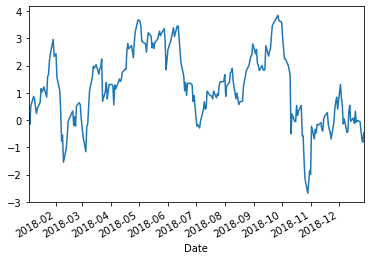

In [31]:
mp_return_df = df_return * df_cap_w[1:]
mp_return = mp_return_df.sum(axis=1)
mp_return.cumsum().plot()

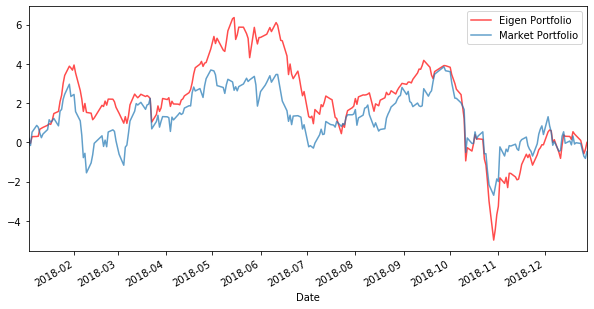

In [32]:
plt.figure(figsize=(10, 5))
ep_return.cumsum().plot(color='red', alpha=.7, label='Eigen Portfolio')
mp_return.cumsum().plot(alpha=.7, label='Market Portfolio')
plt.legend()

#### Eigen Vector 분석

Text(0, 0.5, 'Ratio of Variance Explanation')

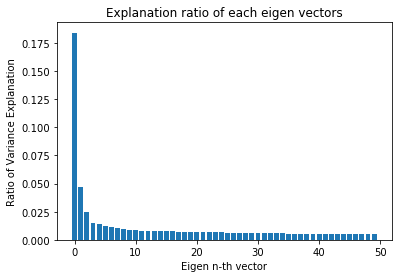

In [33]:
eig_lim = 50
plt.bar(range(eig_lim), pca.explained_variance_ratio_[:eig_lim])
plt.title('Explanation ratio of each eigen vectors')
plt.xlabel('Eigen n-th vector')
plt.ylabel('Ratio of Variance Explanation')

Text(0, 0.5, 'Ratio of Variance Explanation')

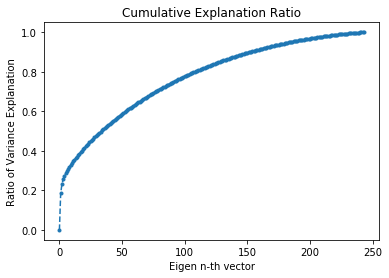

In [34]:
eig_lim = len(pca.explained_variance_ratio_)
plt.plot(range(eig_lim + 1), [0] + list(pca.explained_variance_ratio_[:eig_lim].cumsum()), marker='o', linestyle='--', markersize=3)
plt.title('Cumulative Explanation Ratio')
plt.xlabel('Eigen n-th vector')
plt.ylabel('Ratio of Variance Explanation')

In [35]:
eig_lim = 5
print("Explanation Ratio of {} Eigen vectors: {:.3f}".format(eig_lim, pca.explained_variance_ratio_[:eig_lim].sum()))

Explanation Ratio of 5 Eigen vectors: 0.285


In [36]:
df_eig_loading = pd.DataFrame()
for i in range(len(pca.components_)):
    df_eig_loading[i] = pd.Series(pca.components_[i])
df_eig_loading.index = df_return.columns
df_eig_loading

0       1       2       3       4       5       6       7    \
Symbol                                                                    
A000020 -0.0395 -0.0348 -0.0610 -0.0297 -0.0085 -0.0812  0.0067  0.0269   
A000040 -0.0145 -0.0307  0.0117 -0.0029 -0.0624 -0.0553  0.0242 -0.0226   
A000050 -0.0343 -0.0095  0.0058 -0.0187  0.0403 -0.0008  0.0665 -0.0551   
A000060 -0.0148 -0.0291  0.0693  0.0224 -0.0132 -0.0667 -0.0890 -0.0318   
A000070 -0.0288 -0.0053  0.0387 -0.0583  0.0597  0.0162  0.0607 -0.0222   
...         ...     ...     ...     ...     ...     ...     ...     ...   
A272550 -0.0314 -0.0194  0.0041 -0.0108  0.0117  0.0183  0.0467  0.0194   
A280360 -0.0202 -0.0158  0.0141 -0.0019 -0.0274  0.0359 -0.0129 -0.0086   
A281820 -0.0349 -0.0451 -0.0302  0.0220 -0.0462  0.0502 -0.0623 -0.0442   
A282330 -0.0157 -0.0162  0.0701 -0.0077  0.0874 -0.0487 -0.0093 -0.0608   
A282690 -0.0115 -0.0195 -0.0008  0.0318 -0.0230  0.0201 -0.0108  0.0466   

            8       9    ...     233     234     235     236     237     238  \
Symbol                   ...                                                   
A000020  0.0064  0.0536  ... -0.0504 -0.0249  0.0154 -0.0446  0.1096  0.0094   
A000040  0.0143  0.0284  ... -0.0043  0.0071  0.0399 -0.0441  0.0170 -0.0539   
A000050 -0.0368 -0.0286  ...  0.0544  0.0502 -0.0265 -0.0366  0.0163  0.0283   
A000060 -0.0328  0.0408  ... -0.0230 -0.0109  0.0144 -0.0071  0.0396 -0.0223   
A000070  0.0125 -0.0611  ... -0.0588  0.0421 -0.0195 -0.0502 -0.0394  0.0088   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
A272550  0.0269 -0.0446  ...  0.0561  0.0090  0.0088  0.0818  0.0352  0.0068   
A280360  0.0379 -0.0356  ... -0.0228  0.0202  0.0183 -0.0454  0.0332  0.0045   
A281820  0.0193 -0.0303  ... -0.0325 -0.0545  0.0215 -0.0389 -0.0389 -0.0293   
A282330  0.0658 -0.0270  ... -0.0183 -0.0253  0.0403  0.0674  0.0437 -0.0598   
A282690  0.0066 -0.0950  ... -0.0059 -0.0670 -0.0472  0.0536 -0.0083 -0.0306   

            239     240     241     242  
Symbol                                   
A000020 -0.0123  0.0138 -0.0039 -0.0443  
A000040  0.0519 -0.0414 -0.0007  0.0324  
A000050  0.0291  0.0389  0.0147 -0.0501  
A000060  0.0136 -0.0425 -0.0570 -0.0213  
A000070 -0.0224 -0.0439  0.0124 -0.0251  
...         ...     ...     ...     ...  
A272550  0.0023 -0.0574 -0.0151  0.0354  
A280360 -0.0330  0.0237 -0.0783  0.0123  
A281820 -0.0519 -0.0304  0.0280 -0.0032  
A282330  0.0409  0.0218 -0.0076  0.0017  
A282690 -0.0205 -0.0002  0.0252  0.0040  

[750 rows x 243 columns]

[Text(0, 0, '화학물질 및 화학제품 제조업; 의약품 제외'),
 Text(0, 0, '화학물질 및 화학제품 제조업; 의약품 제외'),
 Text(0, 0, '화학물질 및 화학제품 제조업; 의약품 제외'),
 Text(0, 0, '화학물질 및 화학제품 제조업; 의약품 제외'),
 Text(0, 0, '전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업'),
 Text(0, 0, '자동차 및 트레일러 제조업'),
 Text(0, 0, '전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업'),
 Text(0, 0, '전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업'),
 Text(0, 0, '화학물질 및 화학제품 제조업; 의약품 제외'),
 Text(0, 0, '소매업; 자동차 제외')]

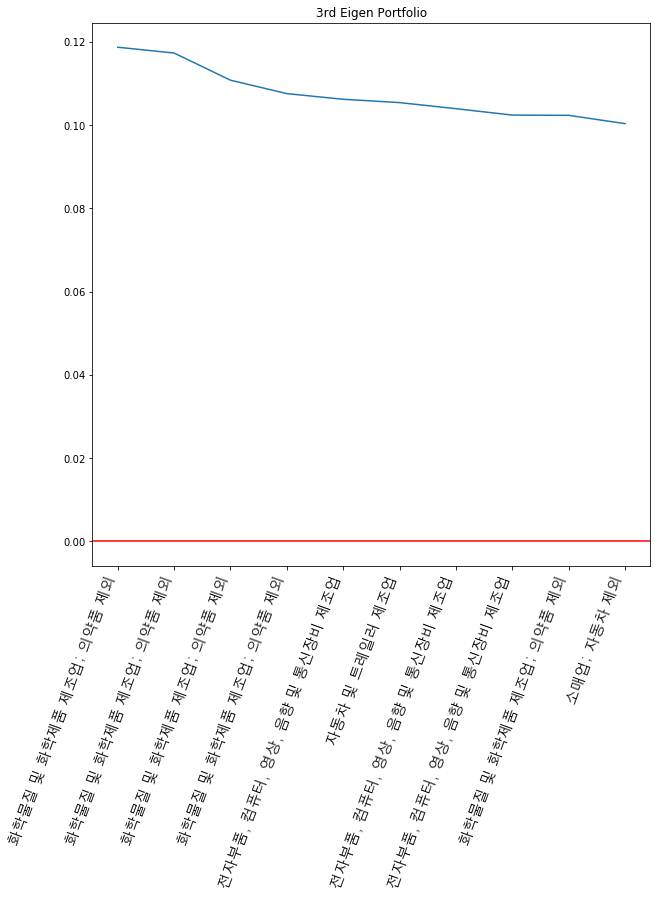

In [37]:
import matplotlib
from matplotlib.font_manager import FontProperties
%matplotlib inline

# matplotlib.rc('font', family='HYsanB') 

font_path = 'C:/Windows/Fonts/H2GTRM.TTF'
fontprop = FontProperties(fname=font_path, size=15)
n_th = 5
df_eig_loading = df_eig_loading.sort_values(by=[n_th], ascending=False)

f, ax = plt.subplots(1,1, figsize=(10,10))
# x = df_eig_loading.index[:]
# y = df_eig_loading[n_th][:]

# Long Top 10 Portfolio
x = df_eig_loading.index[:10]
y = df_eig_loading[n_th][:10]

# Short Top 10 Portfolio
# x = df_eig_loading.index[-10:]
# y = df_eig_loading[n_th][-10:]

xx = list(sector_df.loc['중분류', x])

ax.set_title('3rd Eigen Portfolio')
ax.plot(x, y)
ax.axhline(0, color='r')
ax.set_xticklabels(xx, rotation=70, ha='right', fontproperties=fontprop)

### Linear Regression

#### 모든 주식의 추정된 회귀계수(Coefficients) Matrix 생성

In [38]:
df_eig = pd.DataFrame()
eig_lim = 5
for i in range(eig_lim):
    df_eig[i] = df_return.mul(pca.components_[i], axis=1).sum(axis=1)
df_eig

0       1        2       3       4
Date                                               
2018-01-03 -3.5432 -0.5557  -4.4119  1.1070 -5.1421
2018-01-04  4.7109  5.5640   0.0102  2.1319 -6.3433
2018-01-05 -8.7842 -6.2491  -1.0008 -4.3037 -5.0186
2018-01-08 -0.1702 -1.4307   3.8245 -2.5118 -5.2568
2018-01-09 -0.3383 -1.7641   5.5907 -0.2168  1.9722
...            ...     ...      ...     ...     ...
2018-12-21  2.1823 -1.0692  -1.4132 -3.0195 -3.3674
2018-12-24  6.2925  1.1746   2.1075  0.4103 -3.3044
2018-12-26 17.5016  1.6378  -2.2119  0.7514 -0.9646
2018-12-27 -5.6331 -0.6397 -11.3059 -5.0435  3.5932
2018-12-28 -9.2270 -4.0449  -4.5888  1.1326 -0.9472

[243 rows x 5 columns]

In [39]:
df_reg = df_eig.copy()
df_reg = sm.add_constant(df_reg)
df_reg

C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const       0       1        2       3       4
Date                                                      
2018-01-03 1.0000 -3.5432 -0.5557  -4.4119  1.1070 -5.1421
2018-01-04 1.0000  4.7109  5.5640   0.0102  2.1319 -6.3433
2018-01-05 1.0000 -8.7842 -6.2491  -1.0008 -4.3037 -5.0186
2018-01-08 1.0000 -0.1702 -1.4307   3.8245 -2.5118 -5.2568
2018-01-09 1.0000 -0.3383 -1.7641   5.5907 -0.2168  1.9722
...           ...     ...     ...      ...     ...     ...
2018-12-21 1.0000  2.1823 -1.0692  -1.4132 -3.0195 -3.3674
2018-12-24 1.0000  6.2925  1.1746   2.1075  0.4103 -3.3044
2018-12-26 1.0000 17.5016  1.6378  -2.2119  0.7514 -0.9646
2018-12-27 1.0000 -5.6331 -0.6397 -11.3059 -5.0435  3.5932
2018-12-28 1.0000 -9.2270 -4.0449  -4.5888  1.1326 -0.9472

[243 rows x 6 columns]

### Clustering

#### Factor Loading 공간 내에서의 Clustering

In [42]:
df_params = pd.DataFrame()
for ticker in df_return.columns:
    results = sm.OLS(df_return.loc[:,ticker] ,df_reg).fit()
    df_params[ticker] = results.params
df_params = df_params.T
df_params

const       0       1       2       3       4
A000020 -0.0000 -0.0395 -0.0348 -0.0610 -0.0297 -0.0085
A000040 -0.0000 -0.0145 -0.0307  0.0117 -0.0029 -0.0624
A000050 -0.0000 -0.0343 -0.0095  0.0058 -0.0187  0.0403
A000060  0.0000 -0.0148 -0.0291  0.0693  0.0224 -0.0132
A000070 -0.0000 -0.0288 -0.0053  0.0387 -0.0583  0.0597
...         ...     ...     ...     ...     ...     ...
A272550  0.0000 -0.0314 -0.0194  0.0041 -0.0108  0.0117
A280360  0.0000 -0.0202 -0.0158  0.0141 -0.0019 -0.0274
A281820  0.0000 -0.0349 -0.0451 -0.0302  0.0220 -0.0462
A282330 -0.0000 -0.0157 -0.0162  0.0701 -0.0077  0.0874
A282690 -0.0000 -0.0115 -0.0195 -0.0008  0.0318 -0.0230

[750 rows x 6 columns]

In [43]:
pd.DataFrame({'Mean': df_params.mean(axis=0), 'Var': df_params.var(axis=0)})

Mean    Var
const -0.0000 0.0000
0     -0.0345 0.0001
1     -0.0048 0.0013
2      0.0014 0.0013
3      0.0001 0.0013
4      0.0013 0.0013

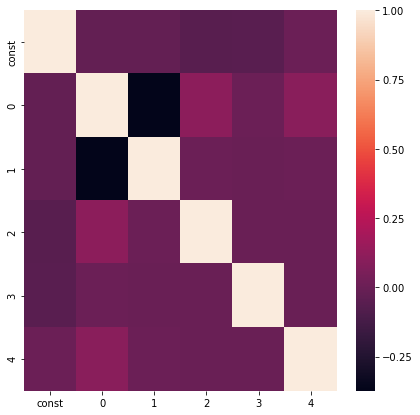

In [44]:
plt.figure(figsize=(7, 7))
sns.heatmap(df_params.corr())

#### Factor Loading의 P-value 공간 내에서의 Clustering

In [46]:
df_pval = pd.DataFrame()
for ticker in df_return.columns:
    results = sm.OLS(df_return.loc[:,ticker] ,df_reg).fit()
    df_pval[ticker] = results.pvalues
df_pval = df_pval.T
df_pval

const      0      1      2      3      4
A000020 1.0000 0.0000 0.0001 0.0000 0.0582 0.5993
A000040 1.0000 0.0061 0.0032 0.4176 0.8726 0.0010
A000050 1.0000 0.0000 0.3362 0.6723 0.2802 0.0252
A000060 1.0000 0.0040 0.0040 0.0000 0.2047 0.4684
A000070 1.0000 0.0000 0.5839 0.0044 0.0007 0.0008
...        ...    ...    ...    ...    ...    ...
A272550 1.0000 0.0000 0.0539 0.7718 0.5431 0.5215
A280360 1.0000 0.0002 0.1319 0.3365 0.9196 0.1513
A281820 1.0000 0.0000 0.0000 0.0194 0.1756 0.0063
A282330 1.0000 0.0016 0.0943 0.0000 0.6486 0.0000
A282690 1.0000 0.0338 0.0684 0.9571 0.0902 0.2358

[750 rows x 6 columns]

In [47]:
pd.DataFrame({'Mean': df_pval.mean(axis=0), 'Var': df_pval.var(axis=0)})

Mean    Var
const 1.0000 0.0000
0     0.0080 0.0034
1     0.1537 0.0692
2     0.2305 0.0892
3     0.2832 0.0982
4     0.3163 0.0970

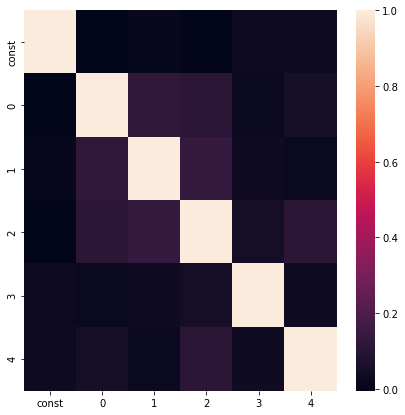

In [48]:
plt.figure(figsize=(7, 7))
sns.heatmap(df_pval.corr())

In [49]:
scaler = StandardScaler()
df_pval_std = scaler.fit_transform(df_pval)

In [50]:
risk_pval_pca = PCA()
risk_pval_pca.fit(df_pval_std)
rpp = risk_pval_pca.transform(df_pval_std)
rpp.shape

(750, 6)

Text(0, 0.5, 'Ratio of Variance Explanation')

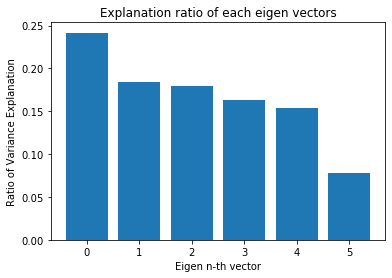

In [51]:
eig_lim = len(risk_pval_pca.explained_variance_ratio_)
plt.bar(range(eig_lim), risk_pval_pca.explained_variance_ratio_[:eig_lim])
plt.title('Explanation ratio of each eigen vectors')
plt.xlabel('Eigen n-th vector')
plt.ylabel('Ratio of Variance Explanation')

In [52]:
df_eig_pval = pd.DataFrame(risk_pval_pca.transform(df_pval_std))
df_eig_pval.index = df_pval.index
df_eig_pval

0       1       2       3       4       5
A000020 -0.6251 -0.2038 -1.1734  0.4389  0.5510 -0.1544
A000040  0.1060 -1.0795  1.7062  0.0866 -1.0940 -0.1668
A000050  0.7511  0.7001  0.6321 -1.0961 -1.0401  1.2199
A000060 -0.6267 -0.3067 -0.5678  0.5116  0.4166 -0.4464
A000070 -0.2948  1.8820  0.6147 -0.6196  0.9425  2.1251
...         ...     ...     ...     ...     ...     ...
A272550  1.1888 -1.1607 -0.2181 -0.5834 -1.1867  0.4337
A280360  0.3510 -1.2342  1.6479 -0.0137 -0.4248  0.1789
A281820 -1.1931  0.4619  0.3539  0.3062 -0.2245 -0.5306
A282330 -0.7074 -0.4212  1.4919  0.4000  0.0731 -0.4486
A282690  1.1780  0.5304 -0.6108 -0.6631 -2.1191  1.1662

[750 rows x 6 columns]

### P value가 유의한 팩터들이 동일한 주식들 구분

In [53]:
pval_thr = 0.05
df_pval_bool = df_pval < pval_thr
df_pval_bool

const     0      1      2      3      4
A000020  False  True   True   True  False  False
A000040  False  True   True  False  False   True
A000050  False  True  False  False  False   True
A000060  False  True   True   True  False  False
A000070  False  True  False   True   True   True
...        ...   ...    ...    ...    ...    ...
A272550  False  True  False  False  False  False
A280360  False  True  False  False  False  False
A281820  False  True   True   True  False   True
A282330  False  True  False   True  False   True
A282690  False  True  False  False  False  False

[750 rows x 6 columns]

In [54]:
def classify_duplicate(df):
    df_c = df.copy()
    df_list = []
    df_non = pd.DataFrame()
    idx_list = df.index
    for idx in idx_list:
        if idx not in df_c.index:
            continue
        # print(idx)
        temp_df = pd.DataFrame()
        # temp_df[idx] = df_c.loc[idx,:]
        temp_series = df_c.loc[idx, :]
        df_c = df_c.drop(idx)
        cnt = 0
        for idx2 in df_c.index:
            if (temp_series == df_c.loc[idx2, :]).all():
                # print(idx, idx2)
                temp_df[idx2] = df_c.loc[idx2, :]
                df_c = df_c.drop(idx2)
                cnt += 1
        if cnt == 0:
            df_non[idx] = temp_series
        else:
            temp_df[idx] = temp_series
            df_list.append(temp_df.T)
    return df_list, df_non.T

In [55]:
classified_list, df_nc = classify_duplicate(df_pval_bool)
print("Class Num: {} \nNotClass Records: {}".format(len(classified_list), len(df_nc)))

Class Num: 18 
NotClass Records: 7


In [56]:
classified_list[1]

const     0     1      2      3     4
A000400  False  True  True  False  False  True
A001510  False  True  True  False  False  True
A002140  False  True  True  False  False  True
A002220  False  True  True  False  False  True
A004560  False  True  True  False  False  True
A004840  False  True  True  False  False  True
A004910  False  True  True  False  False  True
A005930  False  True  True  False  False  True
A006040  False  True  True  False  False  True
A006220  False  True  True  False  False  True
A006980  False  True  True  False  False  True
A007590  False  True  True  False  False  True
A011070  False  True  True  False  False  True
A011500  False  True  True  False  False  True
A011790  False  True  True  False  False  True
A017810  False  True  True  False  False  True
A018260  False  True  True  False  False  True
A023590  False  True  True  False  False  True
A030210  False  True  True  False  False  True
A031440  False  True  True  False  False  True
A032560  False  True  True  False  False  True
A035720  False  True  True  False  False  True
A042700  False  True  True  False  False  True
A073240  False  True  True  False  False  True
A101530  False  True  True  False  False  True
A000040  False  True  True  False  False  True

In [57]:
for i, d in enumerate(classified_list):
    print('{}th cluster: {}'.format(i+1, len(d)))

1th cluster: 74
2th cluster: 26
3th cluster: 14
4th cluster: 12
5th cluster: 44
6th cluster: 59
7th cluster: 49
8th cluster: 62
9th cluster: 116
10th cluster: 67
11th cluster: 37
12th cluster: 86
13th cluster: 14
14th cluster: 26
15th cluster: 8
16th cluster: 23
17th cluster: 23
18th cluster: 3


### 유의한 팩터가 동일한 주식끼리 팩터 로딩 클러스터링

In [59]:
for d in classified_list[:10]:
    target_tickers = d.index
    factor_sig = d.iloc[0,:]
    k = factor_sig.sum()
    print(factor_sig)
    print(k)
    kmeans_pca = KMeans(n_clusters = k, init = 'k-means++', random_state=1)
    kmeans_pca.fit(df_params.loc[target_tickers, factor_sig])
    d['cluster'] = kmeans_pca.labels_

const    False
0         True
1         True
2         True
3        False
4        False
Name: A000060, dtype: bool
3
const    False
0         True
1         True
2        False
3        False
4         True
Name: A000400, dtype: bool
3
const    False
0         True
1        False
2        False
3        False
4         True
Name: A000890, dtype: bool
2
const    False
0         True
1        False
2         True
3         True
4         True
Name: A002240, dtype: bool
4
const    False
0         True
1         True
2         True
3         True
4         True
Name: A000720, dtype: bool
5
const    False
0         True
1         True
2         True
3         True
4        False
Name: A000220, dtype: bool
4
const    False
0         True
1        False
2         True
3        False
4        False
Name: A000150, dtype: bool
2
const    False
0         True
1         True
2        False
3         True
4        False
Name: A000390, dtype: bool
3
const    False
0         True
1         True
2  

In [61]:
classified_list[0]

const     0     1     2      3      4  cluster
A000060  False  True  True  True  False  False        2
A000210  False  True  True  True  False  False        2
A000270  False  True  True  True  False  False        2
A000880  False  True  True  True  False  False        2
A000990  False  True  True  True  False  False        1
...        ...   ...   ...   ...    ...    ...      ...
A195870  False  True  True  True  False  False        1
A204320  False  True  True  True  False  False        2
A267260  False  True  True  True  False  False        0
A268280  False  True  True  True  False  False        1
A000020  False  True  True  True  False  False        1

[74 rows x 7 columns]

In [62]:
i=5
a = df_return.loc[:,classified_list[i].index[classified_list[i]['cluster'] == 2]].iloc[:, :10]
sector_df.loc['중분류', a.columns]

A000220                의료용 물질 및 의약품 제조업
A000520                의료용 물질 및 의약품 제조업
A001360                의료용 물질 및 의약품 제조업
A003000                의료용 물질 및 의약품 제조업
A003060                의료용 물질 및 의약품 제조업
A003090                         전문 서비스업
A003520                의료용 물질 및 의약품 제조업
A004310                의료용 물질 및 의약품 제조업
A004870    전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업
A005500                의료용 물질 및 의약품 제조업
Name: 중분류, dtype: object

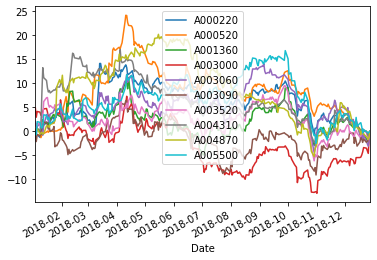

In [63]:
a.cumsum().plot()

In [64]:
def find_cointegrated_pairs(dataframe, critial_level=0.05):
    n = dataframe.shape[1]  # the length of dateframe
    pvalue_matrix = np.ones((n, n))  # initialize the matrix of p
    keys = dataframe.keys()  # get the column names
    pairs = []  # initilize the list for cointegration
    for i in range(n):
        for j in range(i + 1, n):  # for j bigger than i
            stock1 = np.log(dataframe[keys[i]])  # obtain the price of two contract
            stock2 = np.log(dataframe[keys[j]])
            # stock1 = dataframe[keys[i]]  # obtain the price of two contract
            # stock2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2)  # get conintegration
            pvalue = result[1]  # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level:  # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue))  # record the contract with that p-value

    return pvalue_matrix, pairs

In [65]:
target_c = classified_list[0]
stocks = target_c.index[target_c['cluster'] == 0]
pvals, pairs = find_cointegrated_pairs(df_price.loc[:, stocks])
df_pairs = pd.DataFrame(pairs, columns=['s1', 's2', 'pval'])
df_pairs = df_pairs.sort_index(by='pval').reset_index(drop=True)
df_pairs

C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


s1       s2   pval
0   A002900  A071950 0.0002
1   A002030  A025750 0.0029
2   A005960  A047400 0.0079
3   A005960  A103590 0.0119
4   A002030  A012160 0.0144
5   A002030  A002900 0.0158
6   A010820  A025750 0.0189
7   A026940  A071950 0.0207
8   A010820  A014580 0.0240
9   A012160  A071950 0.0281
10  A026940  A267260 0.0330
11  A026940  A047400 0.0385
12  A002030  A010820 0.0419
13  A026940  A103590 0.0430
14  A008250  A010820 0.0470

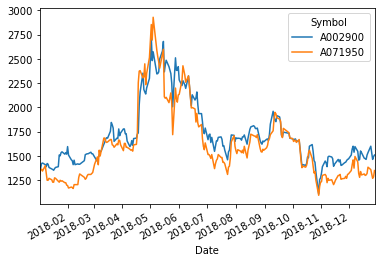

In [68]:
df_price.loc[:, df_pairs.loc[0, ['s1', 's2']]].plot()

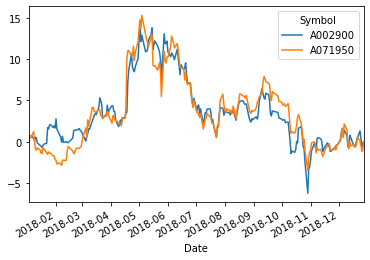

In [69]:
df_return.loc[:, df_pairs.loc[0, ['s1', 's2']]].cumsum().plot()

In [70]:
target_c = classified_list[0]
cluster_list = (target_c['cluster']).unique()
for c in cluster_list:
    stocks = target_c.index[target_c['cluster'] == c]
    find_cointegrated_pairs(df_price.loc[target_date, stocks])
    

IndexError: Item wrong length 576 instead of 244.

In [71]:
df_price[s1].plot()
(df_price[s2]*results.params[1] + results.params[0]).plot()

NameError: name 's1' is not defined

In [72]:
# s1 = 'A002900'
s1 = 'A002030'
# s2 = 'A071950'
s2 = 'A025750'
df_s1 = df_price[s1]
df_s2 = df_price[s2]
df_s2 =  sm.add_constant(df_s2)
results = sm.OLS(df_s1, df_s2).fit()
results.summary()

C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                A002030   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     643.2
Date:                Tue, 19 May 2020   Prob (F-statistic):           4.22e-70
Time:                        05:45:05   Log-Likelihood:                -2500.8
No. Observations:                 244   AIC:                             5006.
Df Residuals:                     242   BIC:                             5013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.856e+04   2760.179     21.214      0.000    5.31e+04     6.4e+04
A025750       42.1034      1.660     25.362      0.000      38.833      45.373
==============================================================================
Omnibus:                       10.009   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               19.578
Skew:                           0.102   Prob(JB):                     5.61e-05
Kurtosis:                       4.373   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

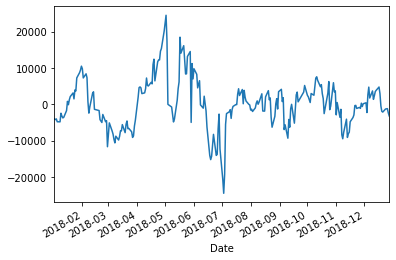

In [73]:
results.resid.plot()

In [75]:
from statsmodels.tsa.stattools import adfuller
adf_rest = adfuller(results.resid)
adf_rest[1]

0.00022914157365672592

In [78]:
adf_coint_test(df_s1, df_s2)

(0.00022914157365672592, 42.10341292959089, 58555.12938731515)

In [77]:
def adf_coint_test(df1, df2):
    df2_temp = df2.copy()
    df2_temp = sm.add_constant(df2_temp)
    results = sm.OLS(df1, df2_temp).fit()
    coint_pval= adfuller(results.resid)[1]
    alpha = results.params[0]
    beta = results.params[1]
    
    return coint_pval, beta, alpha

In [83]:
def find_cointegrated_pairs_adf(dataframe, critial_level=0.02):
    n = dataframe.shape[1]  # the length of dateframe
    pvalue_matrix = np.ones((n, n))  # initialize the matrix of p
    keys = dataframe.keys()  # get the column names
    pairs = []  # initilize the list for cointegration
    for i in range(n):
        for j in range(i + 1, n):  # for j bigger than i
            stock1 = np.log(dataframe[keys[i]])  # obtain the price of two contract
            stock2 = np.log(dataframe[keys[j]])
            # stock1 = dataframe[keys[i]]  # obtain the price of two contract
            # stock2 = dataframe[keys[j]]
            pval, beta, alpha = adf_coint_test(stock1, stock2)  # get conintegration
            pvalue_matrix[i, j] = pval
            if pval < critial_level:  # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pval, beta, alpha))  # record the contract with that p-value

    return pvalue_matrix, pairs

In [84]:
target_c = classified_list[0]
stocks = target_c.index[target_c['cluster'] == 0]
pvals, pairs = find_cointegrated_pairs_adf(df_price.loc[:, stocks])
df_pairs1 = pd.DataFrame(pairs, columns=['s1', 's2', 'pval', 'beta', 'alpha'])
df_pairs1 = df_pairs1.sort_index(by='pval').reset_index(drop=True)
df_pairs1

C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\USER\Anaconda3\envs\py36_ml\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


s1       s2   pval    beta   alpha
0   A002900  A071950 0.0000  0.7619  1.8237
1   A002030  A025750 0.0005  0.5526  7.6674
2   A005960  A047400 0.0016  1.0071  1.3141
3   A005960  A103590 0.0026  0.7797  2.6044
4   A002030  A012160 0.0032  0.5630  7.7249
5   A002030  A002900 0.0036  0.4946  8.0790
6   A010820  A025750 0.0044  1.2699 -1.0780
7   A026940  A071950 0.0049  0.2000  6.4833
8   A010820  A014580 0.0060  1.7217 -5.4509
9   A012160  A071950 0.0069  0.6025  2.7225
10  A026940  A267260 0.0084 -0.0161  8.1205
11  A026940  A047400 0.0100  0.0279  7.7372
12  A002030  A010820 0.0111  0.3525  8.8235
13  A026940  A103590 0.0114  0.0802  7.2816
14  A008250  A010820 0.0127  0.7443  3.1570
15  A001880  A026940 0.0147  0.4073  6.3137

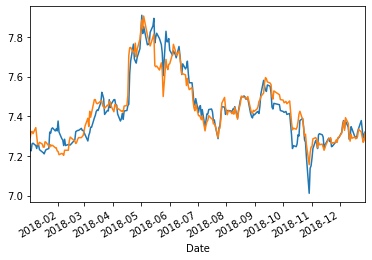

In [117]:
i=0
logp1 = np.log(df_price[df_pairs1.loc[i, 's1']])
logp2 = np.log(df_price[df_pairs1.loc[i, 's2']])
a = df_pairs1.loc[i, 'alpha']
b = df_pairs1.loc[i, 'beta']

pd.Series(logp1).plot()
pd.Series(logp2 * b + a).plot()